In [133]:
# def create_decile(df,column_name):
#     '''
#     Function Created to do a simple Decile Analysis, Comparing Bankrupt and Non Bankrupt instance for a specific 
#     Financial Ratio
    
#     '''
#     deciles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#     decile_values = df[column_name].quantile(deciles)
#     plt.hist([df[column_name][df['BANKRUPTCY_FLAG']==1],
#               df[column_name][df['BANKRUPTCY_FLAG']==0]],
#                  bins=decile_values, range=(-1, 1), alpha=0.5, label=['Bankrupt', 'Not Bankrupt'])
    
#     plt.title(f"Decile Analysis: {column_name}")
#     plt.legend()
#     plt.show()
    
    
def create_decile(df,column_name):
    '''
    Function Created to do a simple Decile Analysis, Comparing Bankrupt and Non Bankrupt instance for a specific 
    Financial Ratio
    
    '''
    
    deciles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    decile_values = df[column_name].quantile(deciles)
    plt.hist([df[column_name][df['BANKRUPTCY_FLAG']==1],
              df[column_name][df['BANKRUPTCY_FLAG']==0]],
                 bins=decile_values, range=(-1, 1), alpha=0.5, label=['Bankrupt', 'Not Bankrupt'])
        
    plt.title(f"Decile Analysis: {column_name}")
    plt.legend()
    plt.show()
    
    return pd.DataFrame(decile_values).T.reset_index().rename(columns={'index':'Financial Ratio'})
    
def review_dataset_dict(df):
    
    '''
    Function Created to Review Dataset for purposes of EDA. Specifically as these are ratios, and through review
    there appeared to be a number of outliers, wanted to be able to simply and easily review not only distribution
    of data, but also simple statistical information about values in columns
    
    
    '''
    
    
    # Create Blank Dict to Store
    blank_dict = {}
    
    # Create Thresholds to Count
    bins = [-np.inf, -1, 0, 1, np.inf]
    labels = ['Value Less than -1%', 'Value between -1 to 0', 'Value Between 0 to 1', 'Value Greater than 1']
    thresh_df = pd.DataFrame()
    
    
    # Loop through columns
    for i in df.columns:
        
        # remove text created variables which crash Python
        if i in ['dataset']:
            pass
        
        temp_df = df[i].copy()
        
        blank_dict[i] = {'null_records':len(temp_df[temp_df.isnull()]),
                         'zero_records':len(temp_df[temp_df==0]),
                         'max_value':temp_df.max(),
                         'min_value':temp_df.min(),
                         'mean_value':temp_df.mean(),
                         'std_dev':temp_df.std(),
                         'positive_values':len(temp_df[temp_df>0]),
                         'negative_values':len(temp_df[temp_df<0])}
        
        record_count = pd.cut(df[i], bins=bins, labels=labels, right=False)
        
        thresh_df = pd.concat([thresh_df,pd.DataFrame(record_count.value_counts().values,index=record_count.value_counts().index,columns=[i]).T])
    
    final_df = pd.DataFrame(blank_dict.values(),index=blank_dict.keys())

    return final_df.merge(thresh_df,left_index=True,right_index=True).reset_index().rename(columns={'index':'Financial Ratio'})

def clean_string(string,remove_chars=['+','-',"(",")",'/','*']):
    
    '''
    Function to clean some of the punctuation which appears in Column Headers
    
    '''
    new_string = ""
    for char in string:
        if char not in remove_chars:
            new_string +=char
    return new_string

def create_heatmap(df,column_name='',corr_value=.1,figsize=(20,15)):
    
    sns.set(style='white')
    
    # View column with Abbreviated title or full. Abbreviated displays nicer.
    corr = df.corr()
    
    if len(column_name)!=0:
        corr = corr[[column_name]]
        corr = corr[abs(corr[column_name])>corr_value]
    
    mask= np.zeros_like(corr,dtype=bool)
    mask[np.triu_indices_from(mask)]=True
    f,ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(220,10,as_cmap=True)
    sns.heatmap(corr,mask=mask,cmap=cmap,vmax=.3,center=0,square=True,linewidths=.5)
    
    plt.title('Heat Map of Correlation')
    plt.show()
    
    
def create_column_inclusion_review(df,
                               columns,
                               column_type_df='',
                               decile_review_df=''):
    
    df = df[columns].copy()
    
    temp_df = review_dataset_dict(df)
    
    if len(column_type_df)!=0:
        temp_df = temp_df.merge(column_type_df,on='Financial Ratio',how='left')
    if len(decile_review_df)!=0:
        temp_df = temp_df.merge(decile_review_df,on='Financial Ratio',how='left')
    
    return temp_df


def variable_review(df,
                    column_name,
                    og_column,
                    column_inclusion_review_df,
                    corr_weight=.15):
        
    print(column_inclusion_review_df[column_inclusion_review_df['Financial Ratio']==column_name].T)
    print(f"\n")
    
    create_heatmap(df[og_columns],column_name)
    create_decile(df,column_name)
    
    print('Top 20 Records')
    print(df.sort_values(column_name)[[column_name,'BANKRUPTCY_FLAG']].tail(20))
    
    print('Bottom 20 Records')
    print(df.sort_values(column_name)[[column_name,'BANKRUPTCY_FLAG']].head(20))
    
    return df[df[column_name].isnull()].T

### Project Scope

The goal of our project is to determine whether we can create a model which predicts whether a company will go Bankruptm based on Financial Ratio.


### Data Source

##### https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data

## Import Libraries

In [33]:
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from tensorflow import keras
from tensorflow.keras import layers

import os
import math
import seaborn as sns

pd.set_option('display.float_format', '{:.2f}'.format)

## Import Data 


In [35]:
df = pd.DataFrame()


# Read Annual Files downloaded from https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data
for i in [x for x in os.listdir() if x.find('.arff')!=-1]:
    temp_df = pd.DataFrame(arff.loadarff(i)[0])
    temp_df['dataset']=i
    df = pd.concat([df,temp_df])

# Change Column Header Names to respective Financial Ratio, Excel Manually Compiled from Read Me.
column_data = pd.read_excel('polish_company_data.xlsx')
column_data['COLUMN_NAME'] = column_data['COLUMN_NAME'].apply(lambda x:x.replace('X','Attr'))
column_data.loc[64,'COLUMN_NAME']='class'
column_data.loc[64,'FINANCIAL_RATIO']='BANKRUPTCY_FLAG'

df = df.rename(columns={column_data['COLUMN_NAME'].tolist()[x]:column_data['FINANCIAL_RATIO'].tolist()[x] for x in range(len(column_data['COLUMN_NAME']))})

# Convert Bankruptcy Flag into INT.
df['BANKRUPTCY_FLAG'] = df['BANKRUPTCY_FLAG'].apply(lambda x:int(x))

# Create a list of original column names, supports visualizations utilized below
og_columns = [x for x in df.columns if x not in ['dataset']]

## Initial Data Review

In [36]:
column_inclusion_review_df = create_column_inclusion_review(df,og_columns)
column_inclusion_review_df

,Financial Ratio,null_records,zero_records,max_value,min_value,mean_value,std_dev,positive_values,negative_values,Value Between 0 to 1,Value between -1 to 0,Value Less than -1%,Value Greater than 1
0,net profit / total assets,8,240,94.28,-463.89,0.04,2.99,33865,9292,33999,9106,186,106
1,total liabilities / total assets,8,89,480.96,-430.87,0.59,5.84,43305,3,41116,0,3,2278
2,working capital / total assets,8,24,28.34,-479.96,0.11,5.44,33804,9569,33797,9134,435,31
3,current assets / short-term liabilities,134,2,53433.00,-0.40,6.31,295.43,43267,2,9569,2,0,33700
4,[(cash + short-term securities + receivables -...,89,43,1250100.00,-11903000.00,-385.35,61243.03,21356,21917,319,254,21663,21080
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,sales / receivables,102,122,108000.00,-12.66,17.03,553.05,43175,6,670,4,2,42627
61,(short-term liabilities *365) / sales,127,121,25016000.00,-2336500.00,1502.33,139266.70,43153,4,157,0,4,43117
62,sales / short-term liabilities,134,118,23454.00,-1.54,9.34,124.18,43149,4,1539,3,1,41728
63,sales / fixed assets,812,88,294770.00,-10677.00,72.79,2369.34,42500,5,3437,3,2,39151


### Identify Words in Colums to Determine potential Similarity

In [37]:
# Create a Dictionary of Words from Column Name to Thematically see what type of data we have available.
# First Review Identified a number of undesired Strings, created function to Clean.

column_data['CLEAN'] = column_data['FINANCIAL_RATIO'].apply(lambda x:clean_string(x))


# Count Occurances of Every Word in Column

word_dictionary = {}

for i in column_data['CLEAN']:
    word = i.split()
    for i in word:
        try:
            word_dictionary[i] +=1
        except:
            word_dictionary[i] =1
            
wd_df = pd.DataFrame(word_dictionary.values(),index=word_dictionary.keys(),columns=['word_count'])
wd_df.head()

,word_count
net,4
profit,23
total,33
assets,30
liabilities,24


### Incorporate Classification of Column into Initial Review

In [164]:
# Apply knowledge of financial ratios to determine ratios are likely to be similiar, and thus in potential duplication
# and to assist with determining which metrics to apply

column_type_df = pd.DataFrame(df.columns,columns=['Financial Ratio'])

condition = [column_type_df['Financial Ratio'].str.contains('working capital'),
             column_type_df['Financial Ratio'].str.contains('profit|EBIT|expenses|cost of'),
             column_type_df['Financial Ratio'].str.contains('assets|equity|retained|capital'),
             column_type_df['Financial Ratio'].str.contains('sales|receivables|inventory'),
             ]

values = ['Liqudity Ratio',
          'Profitability Ratio',
          'Capitalization Ratio',
          'Turnover Ratio']

column_type_df['Ratio Classification'] = np.select(condition,values,'Other')

column_inclusion_review_df = create_column_inclusion_review(df,
                                                            og_columns,
                                                            column_type_df)

column_inclusion_review_df

,Financial Ratio,null_records,zero_records,max_value,min_value,mean_value,std_dev,positive_values,negative_values,Value Between 0 to 1,Value between -1 to 0,Value Less than -1%,Value Greater than 1,Ratio Classification
0,net profit / total assets,8,240,94.28,-463.89,0.04,2.99,33865,9292,33999,9106,186,106,Profitability Ratio
1,total liabilities / total assets,8,89,480.96,-430.87,0.59,5.84,43305,3,41116,0,3,2278,Capitalization Ratio
2,working capital / total assets,8,24,28.34,-479.96,0.11,5.44,33804,9569,33797,9134,435,31,Liqudity Ratio
3,current assets / short-term liabilities,134,2,53433.00,-0.40,6.31,295.43,43267,2,9569,2,0,33700,Capitalization Ratio
4,[(cash + short-term securities + receivables -...,89,43,1250100.00,-11903000.00,-385.35,61243.03,21356,21917,319,254,21663,21080,Profitability Ratio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,sales / receivables,102,122,108000.00,-12.66,17.03,553.05,43175,6,670,4,2,42627,Turnover Ratio
61,(short-term liabilities *365) / sales,127,121,25016000.00,-2336500.00,1502.33,139266.70,43153,4,157,0,4,43117,Turnover Ratio
62,sales / short-term liabilities,134,118,23454.00,-1.54,9.34,124.18,43149,4,1539,3,1,41728,Turnover Ratio
63,sales / fixed assets,812,88,294770.00,-10677.00,72.79,2369.34,42500,5,3437,3,2,39151,Capitalization Ratio


### Visual Review of Data

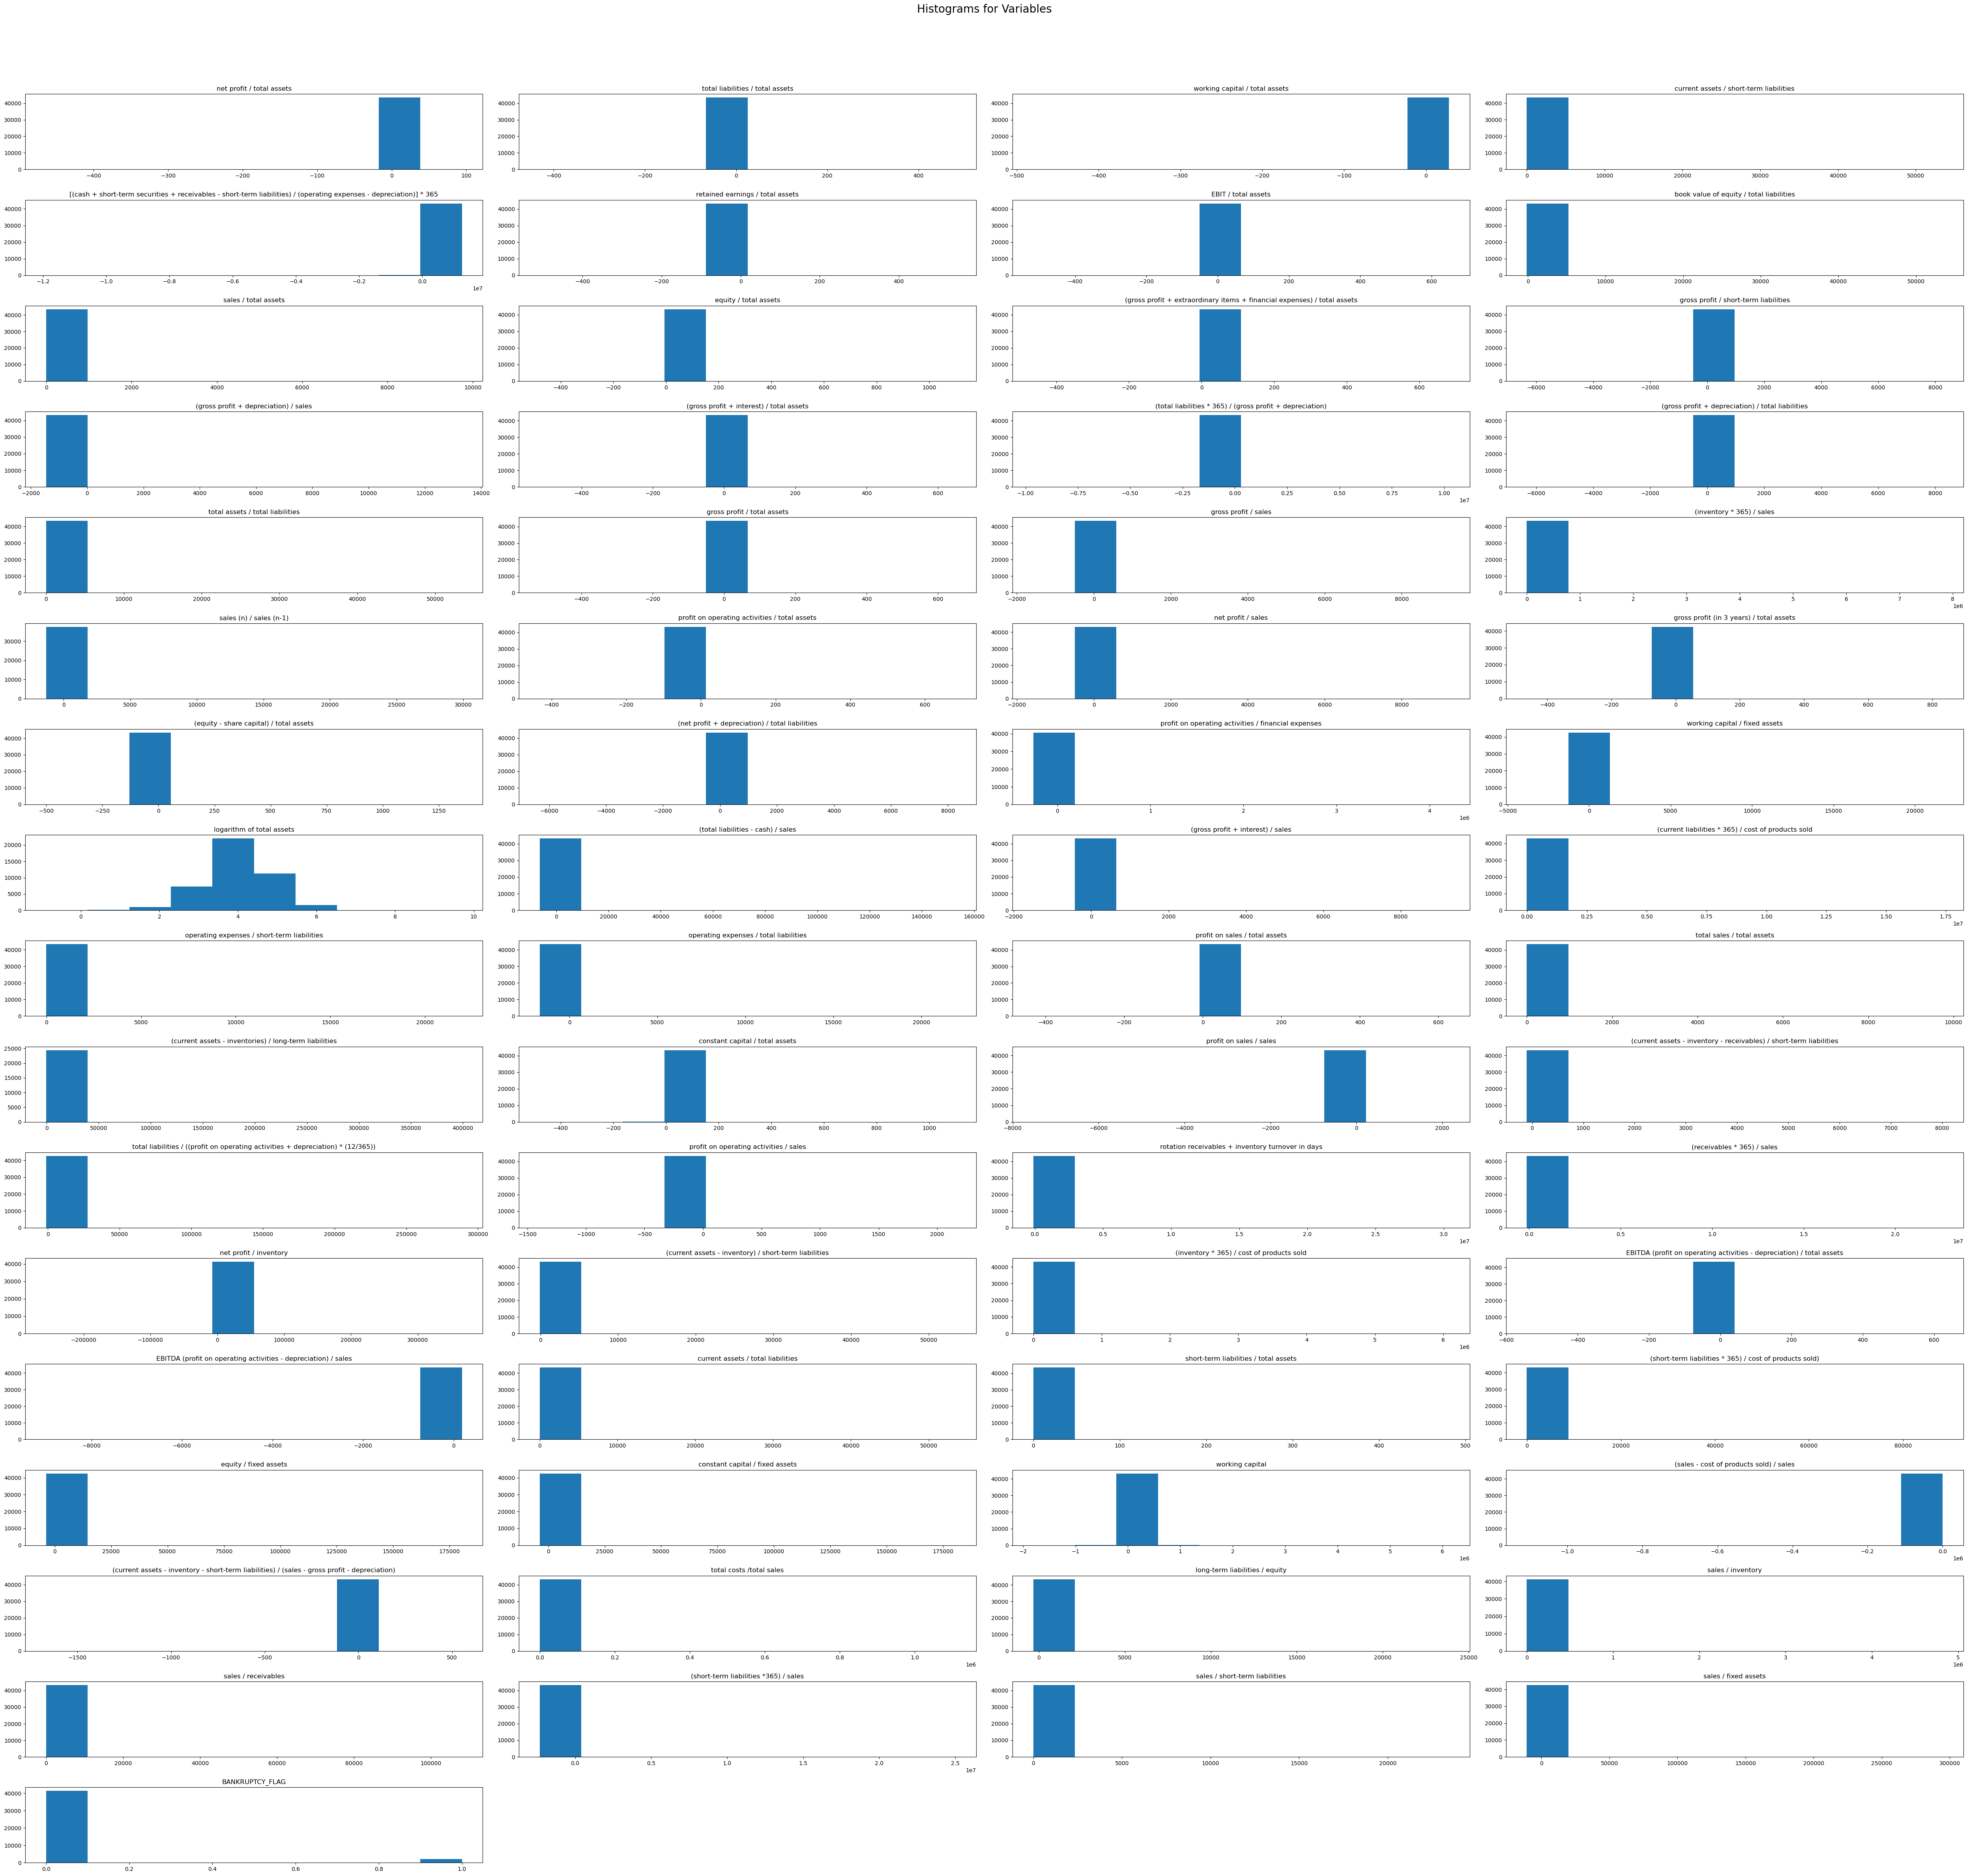

In [39]:
# Remove Unwanted Columns for review purposes.

df1 = df.drop('dataset',axis=1)

# Histogram View

fig = plt.figure(figsize=(50,50))

plt.suptitle('Histograms for Variables',fontsize='20')

l = math.ceil(len(df1.columns)/4)

for i in range(len(df1.columns)):
    plt.subplot(l,4,i+1)
    f = plt.gca()
    f.set_title(df1.columns[i])
    
    plt.hist(df1.iloc[:,i])
    
plt.tight_layout(rect=[0,0.03,1,.95])

#plt.savefig("eda.pdf")

## Review Deciles of Data.

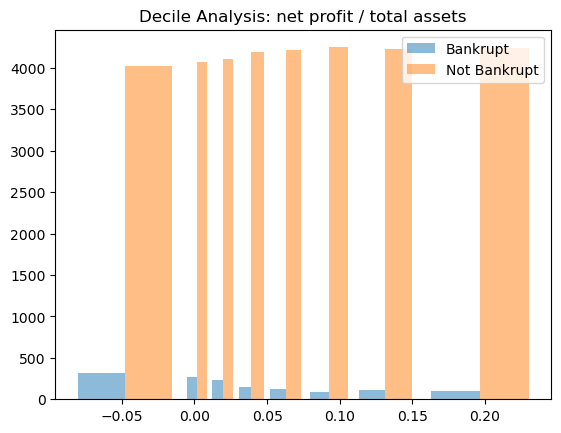

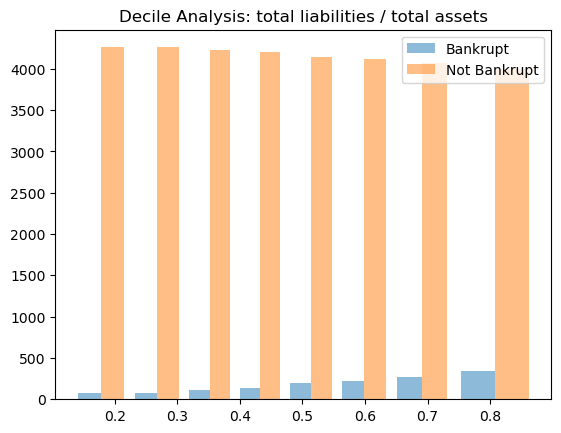

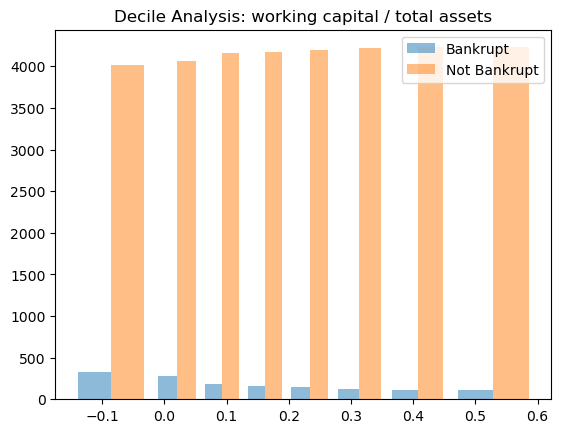

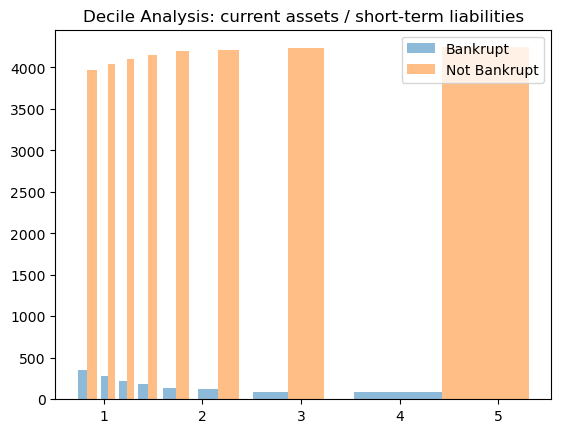

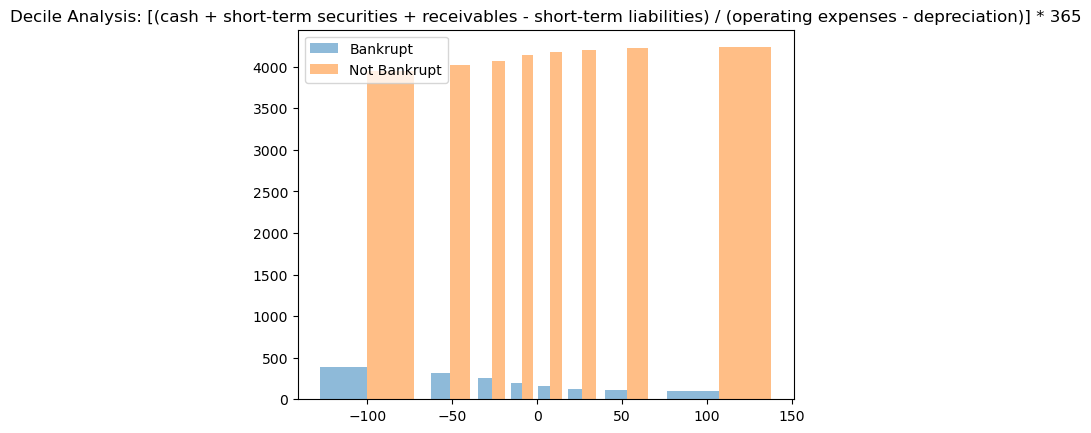

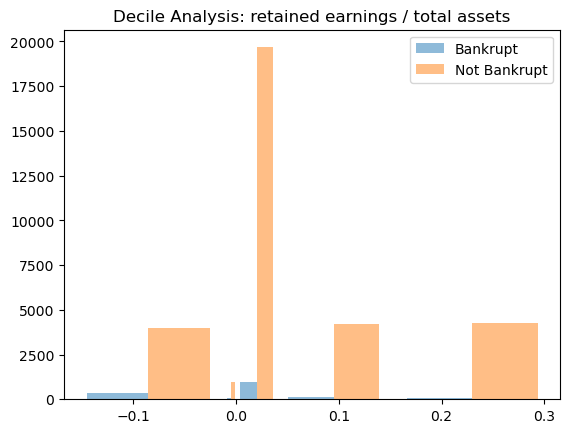

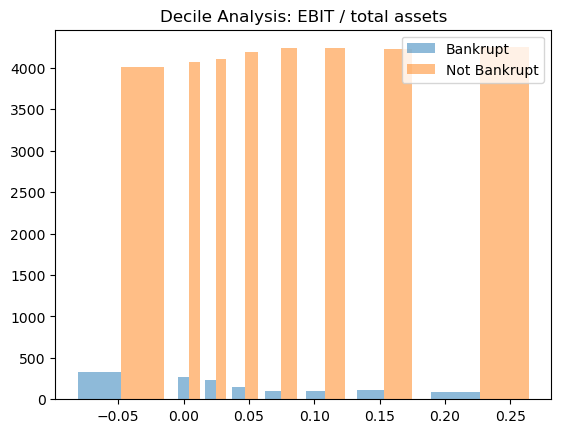

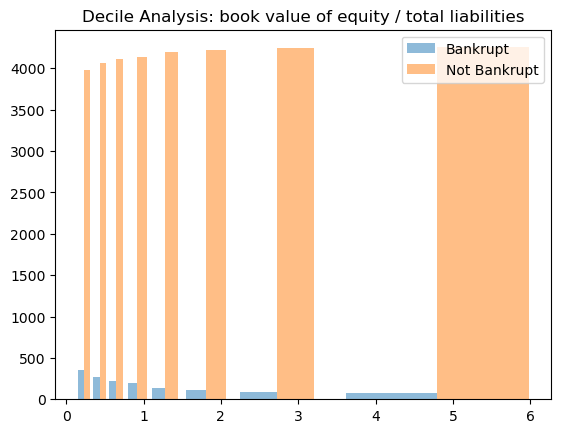

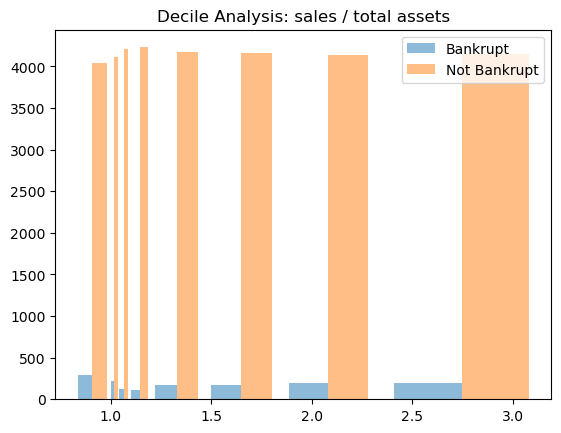

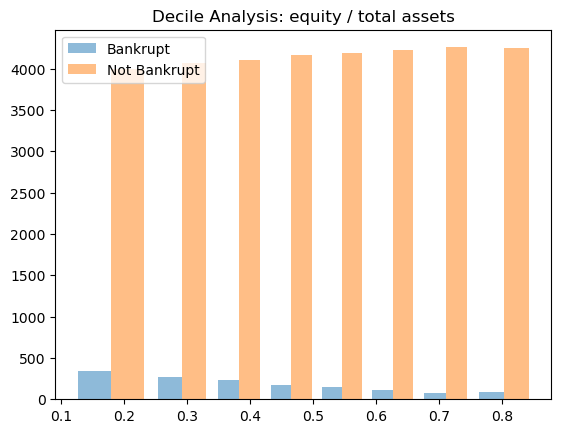

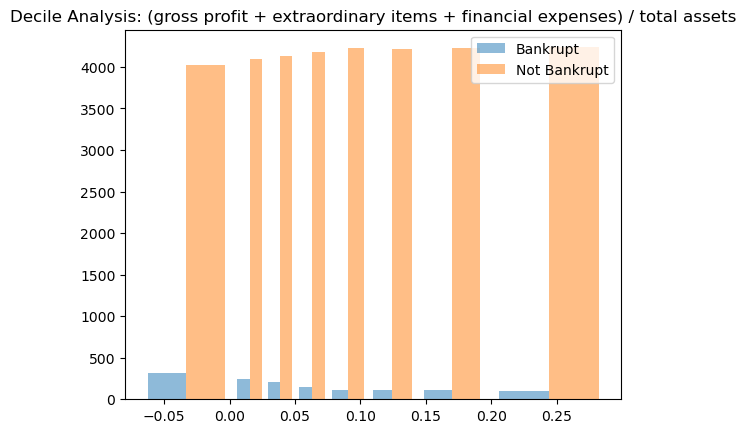

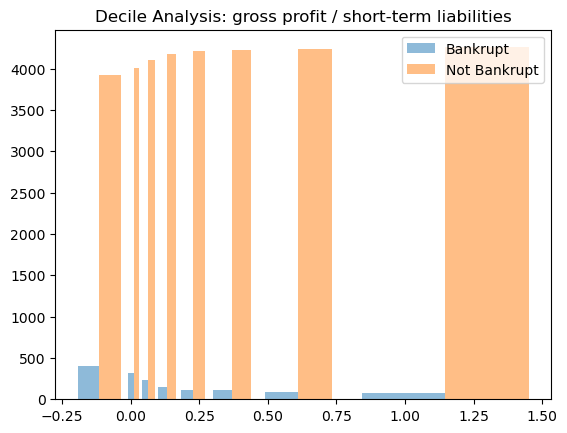

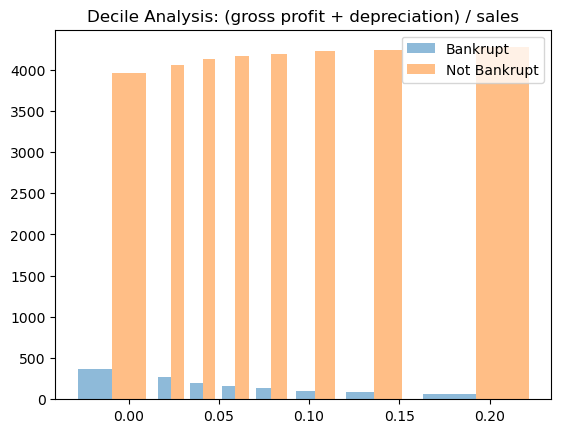

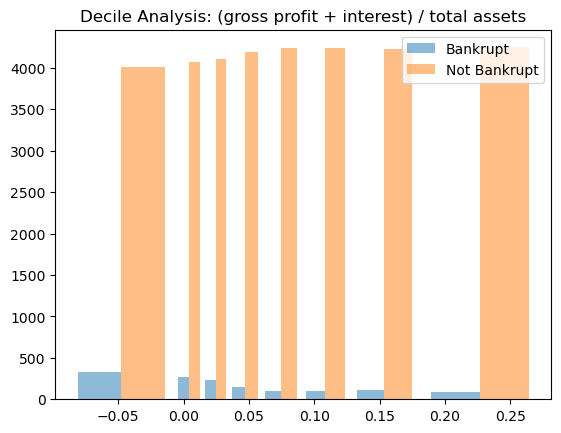

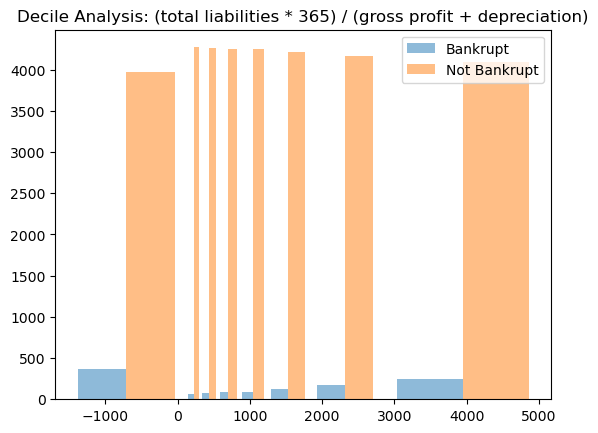

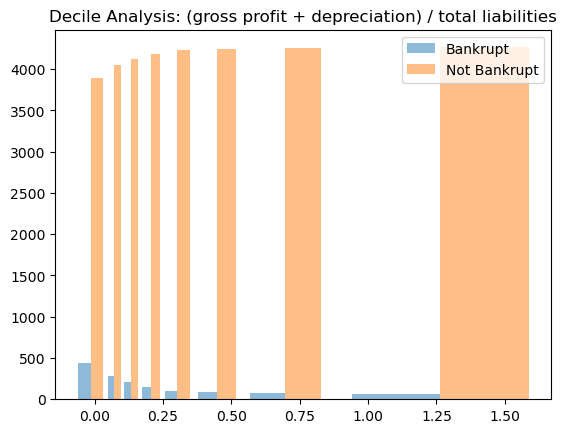

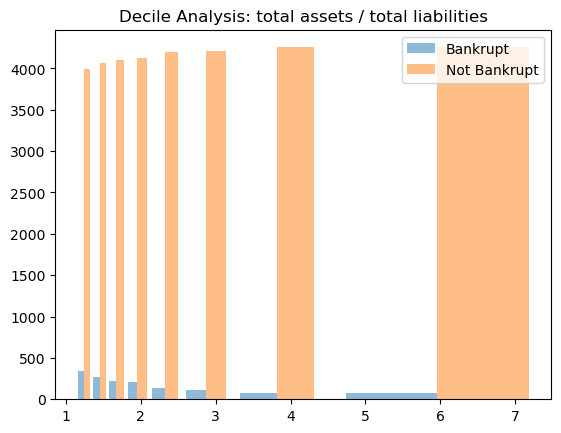

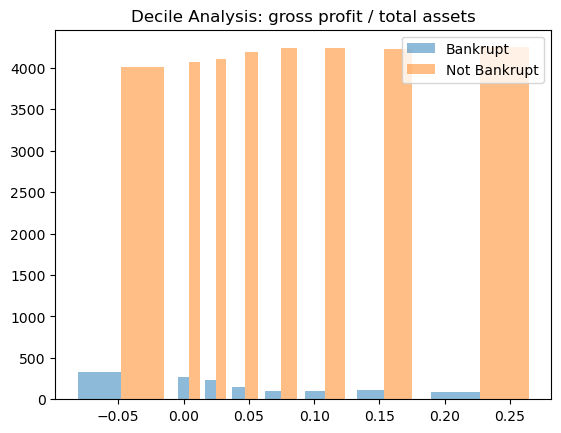

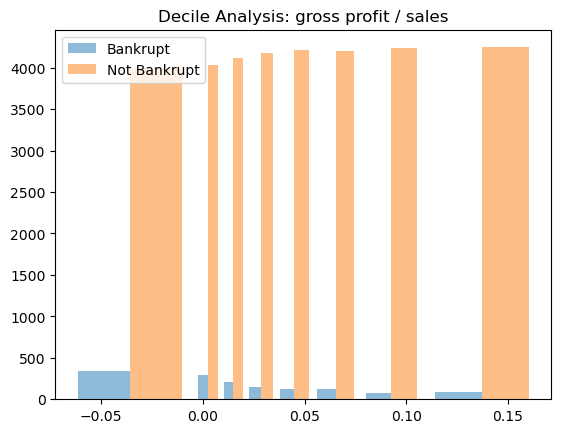

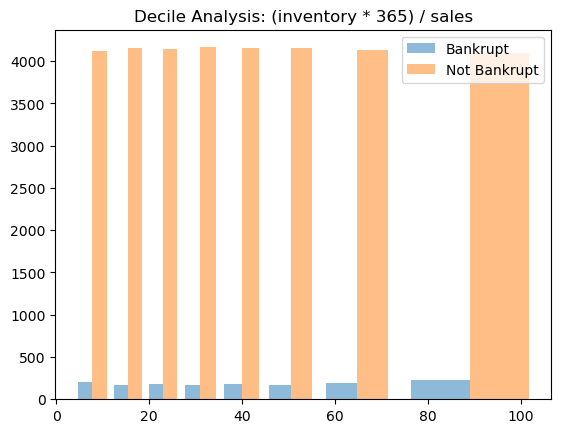

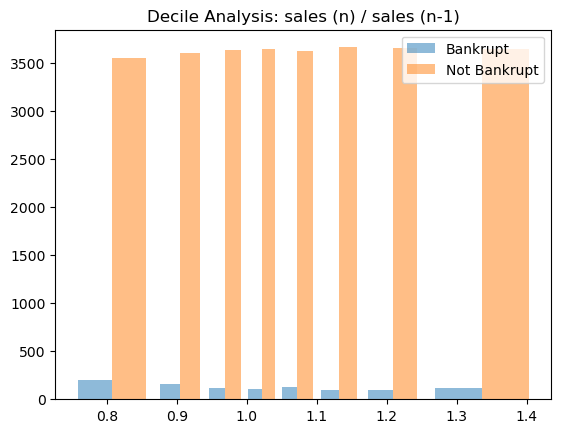

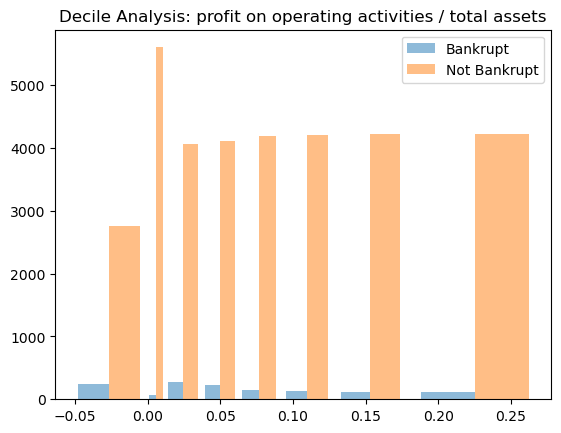

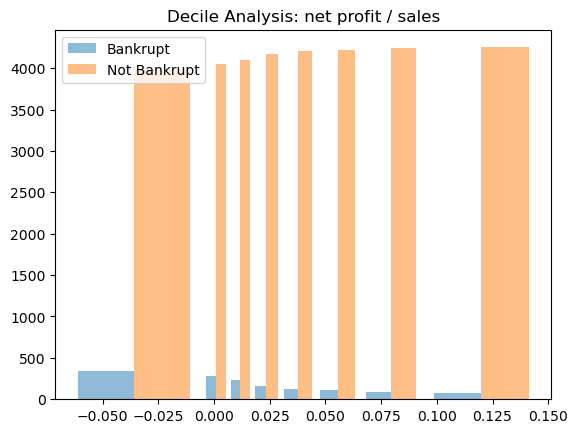

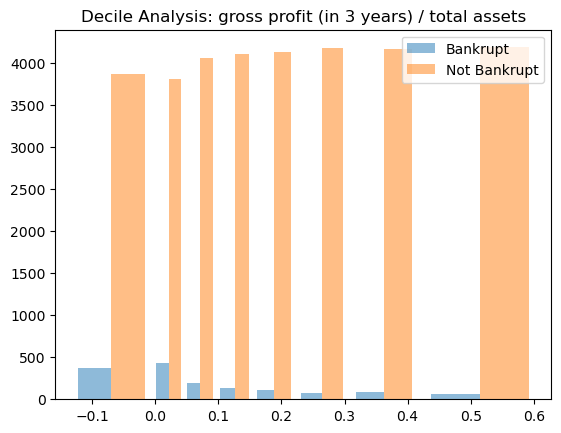

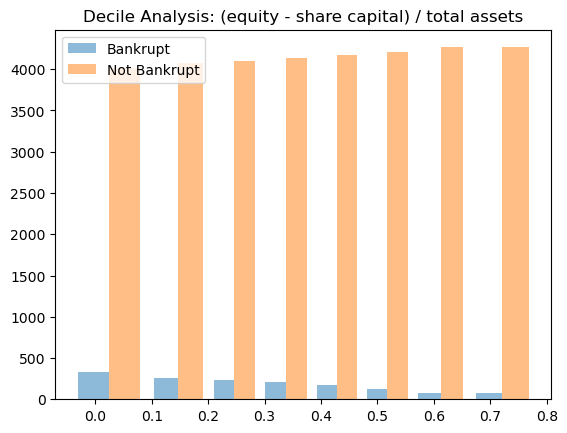

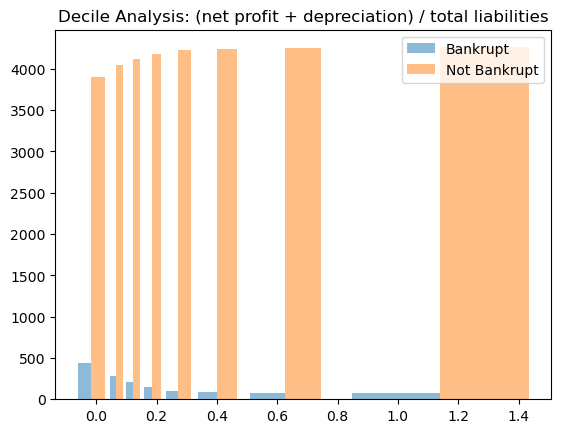

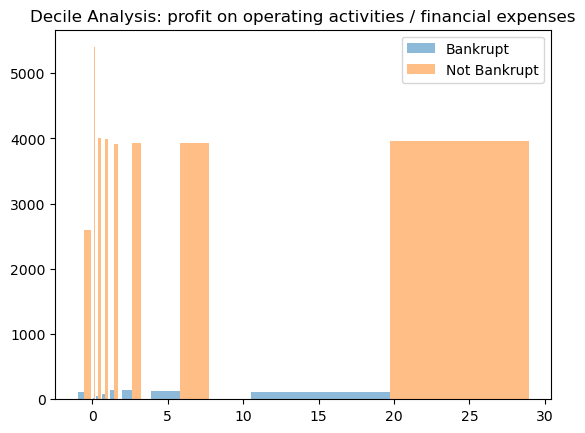

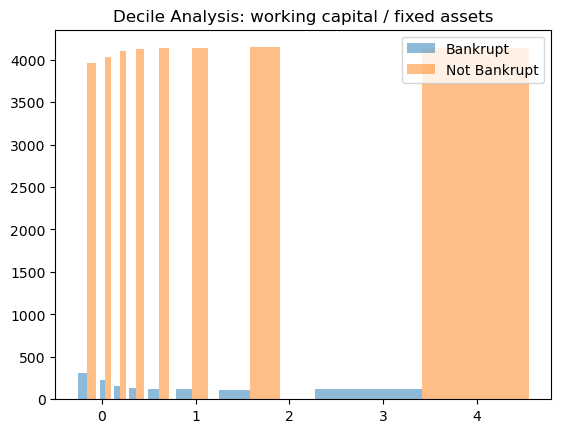

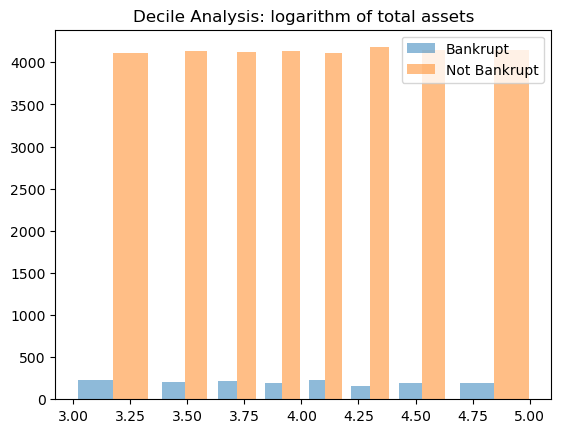

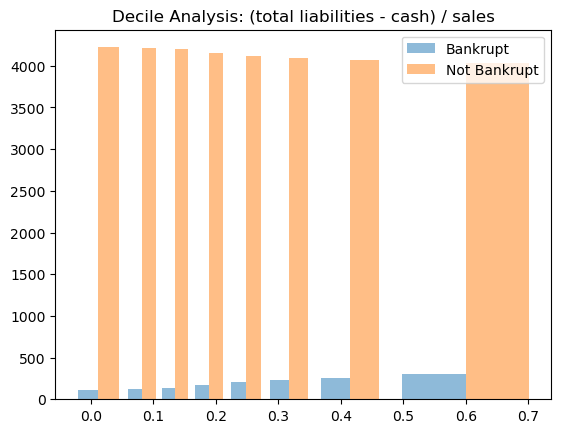

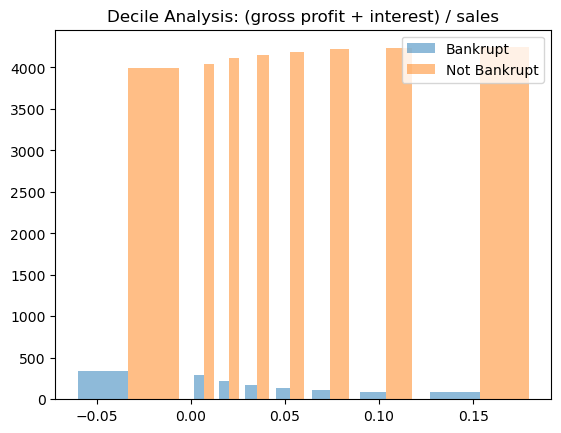

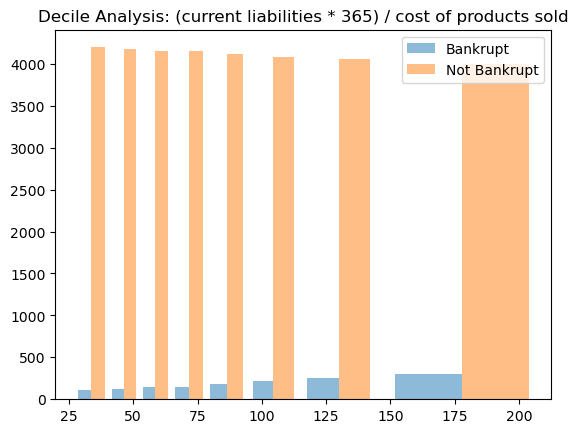

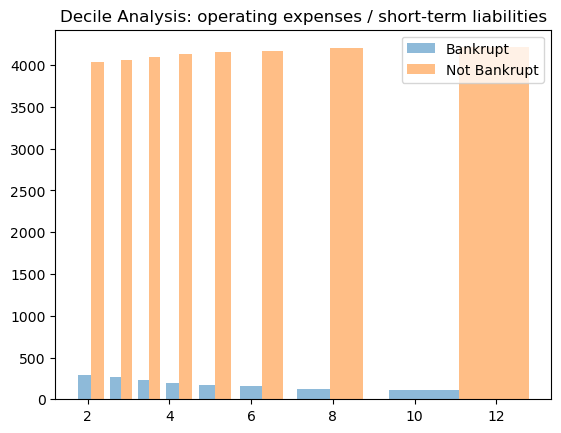

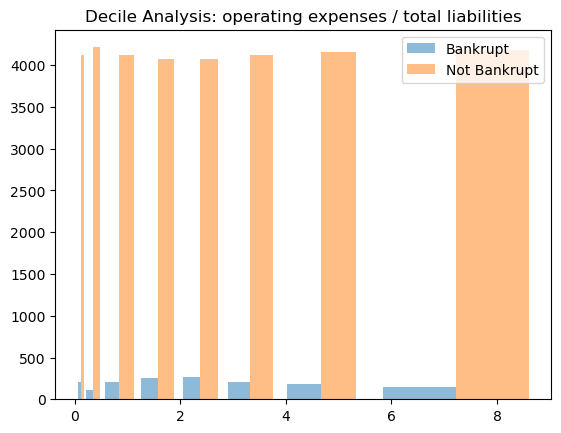

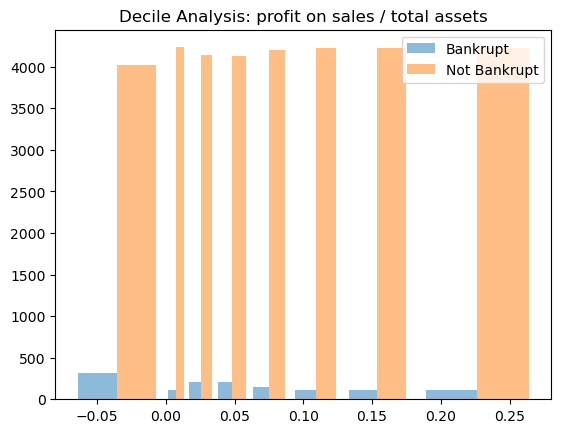

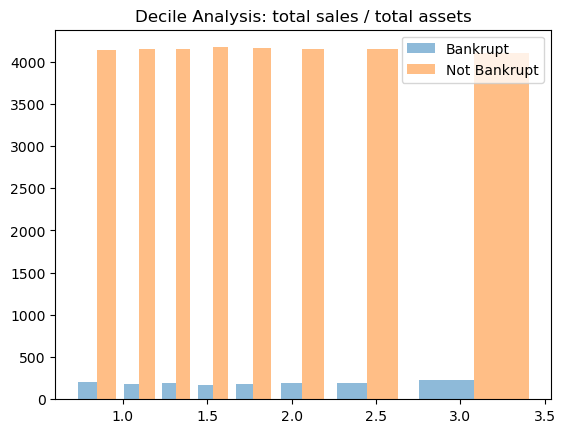

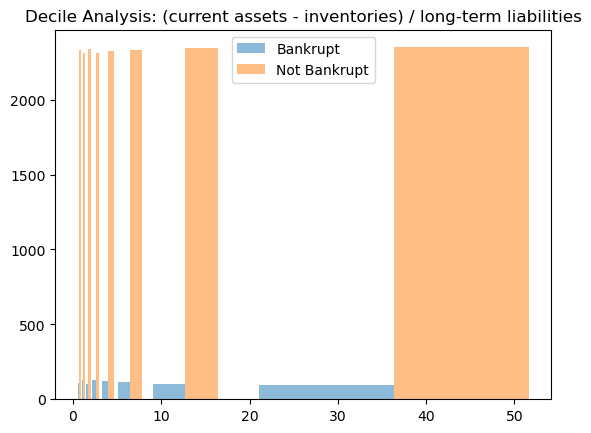

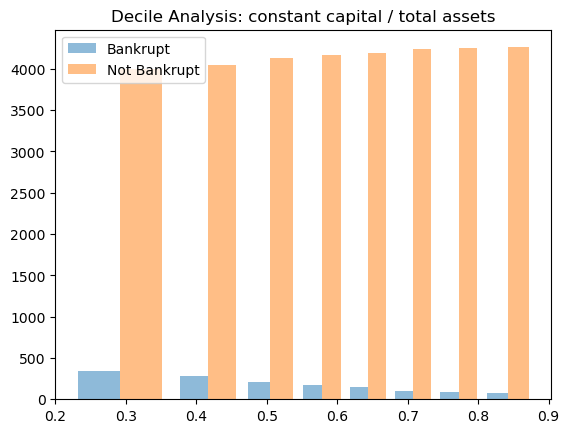

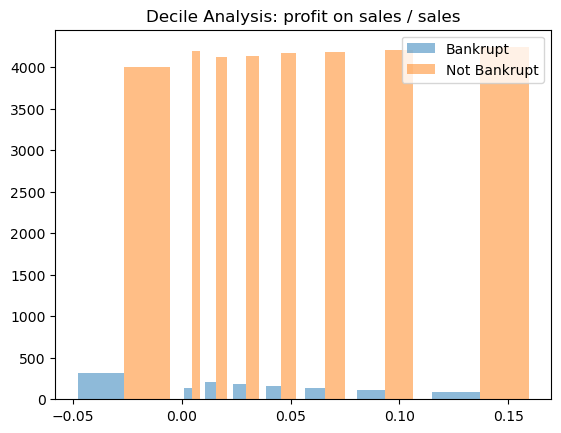

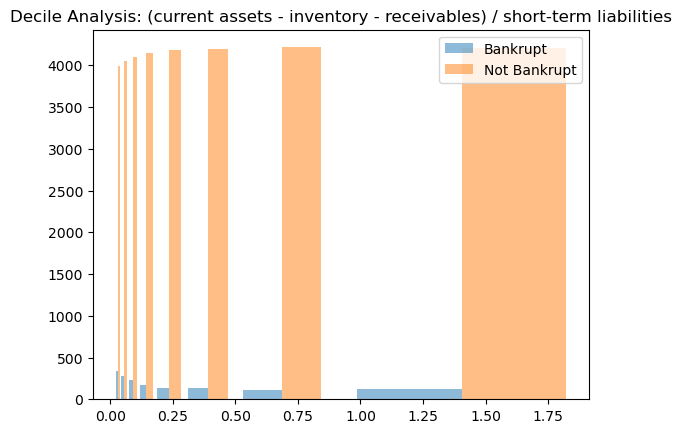

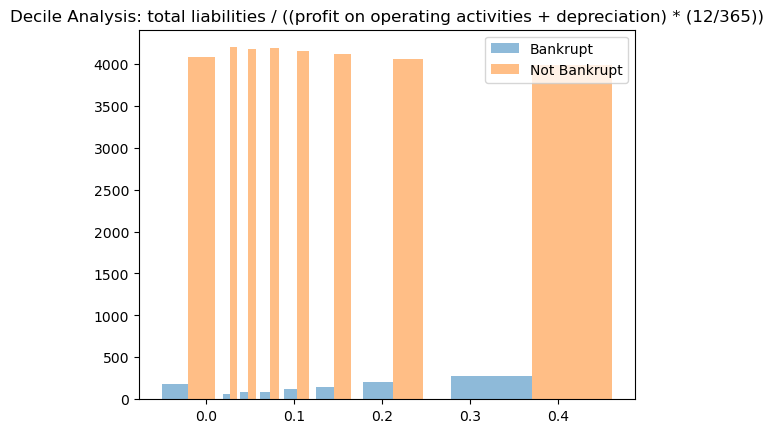

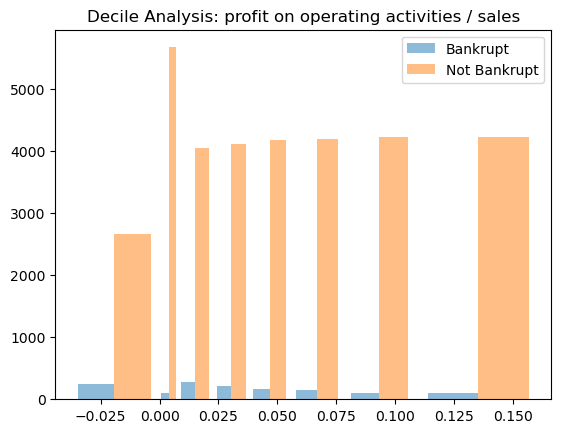

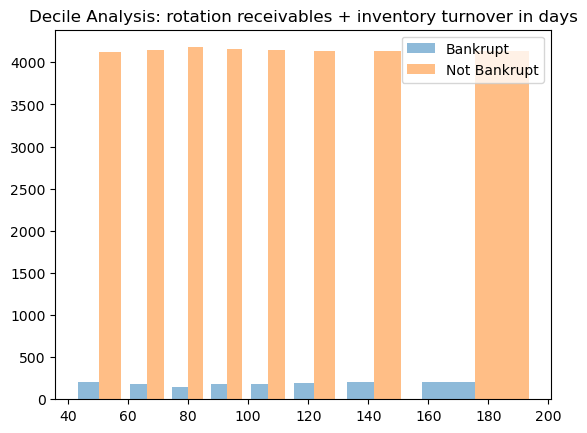

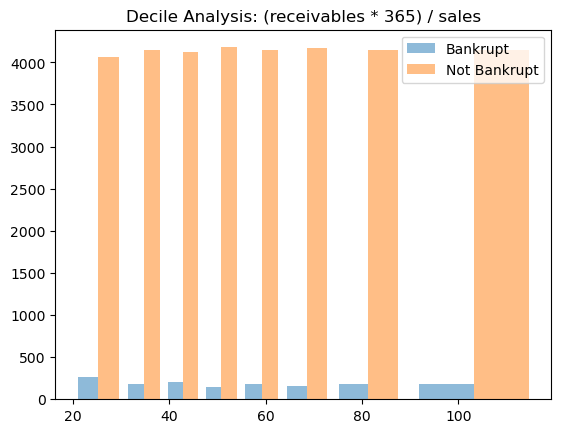

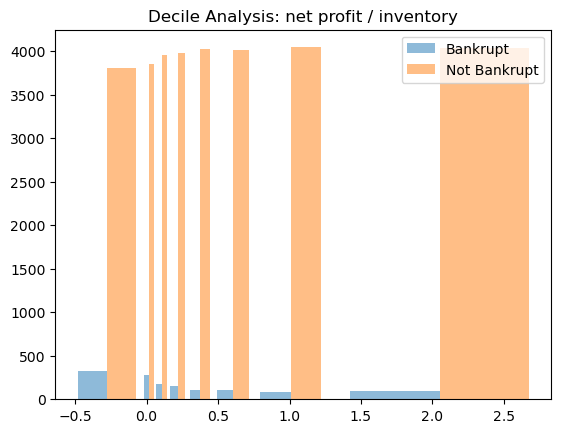

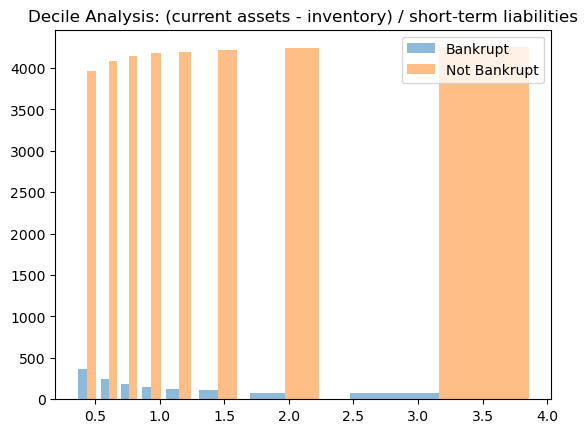

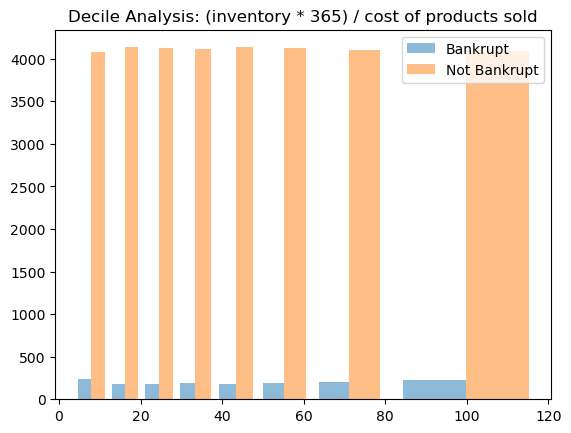

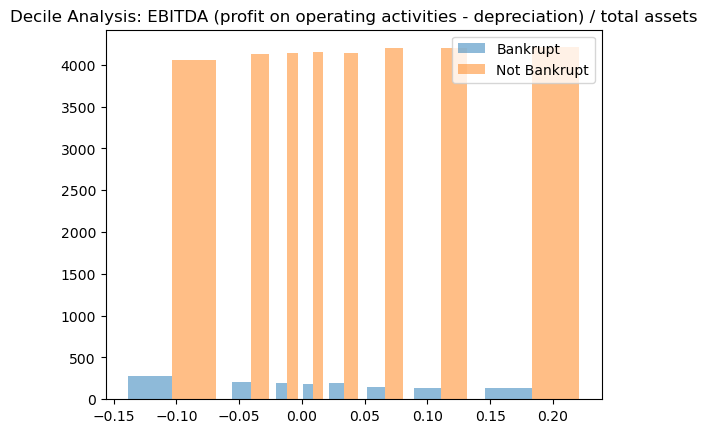

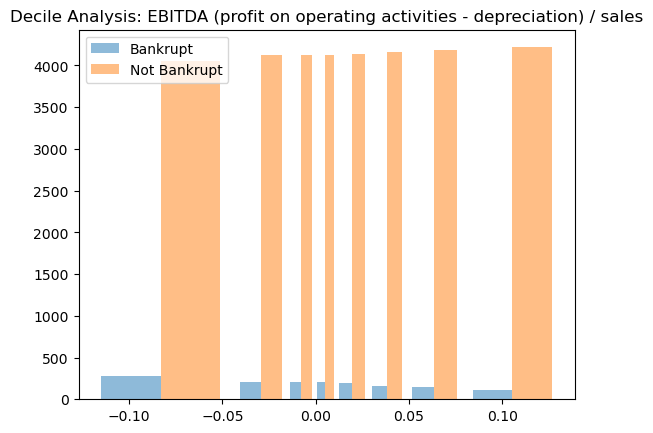

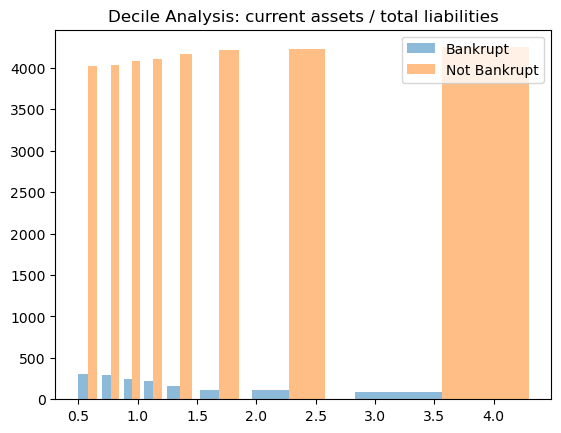

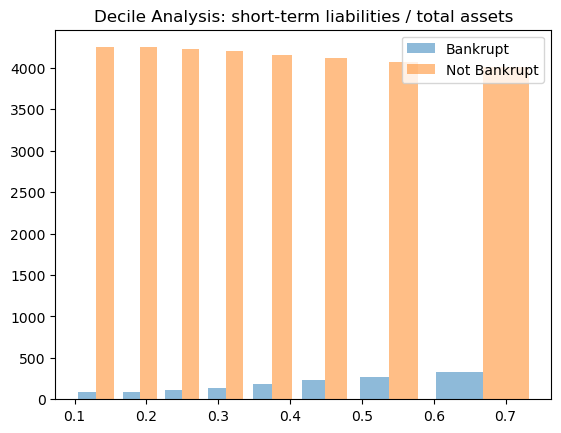

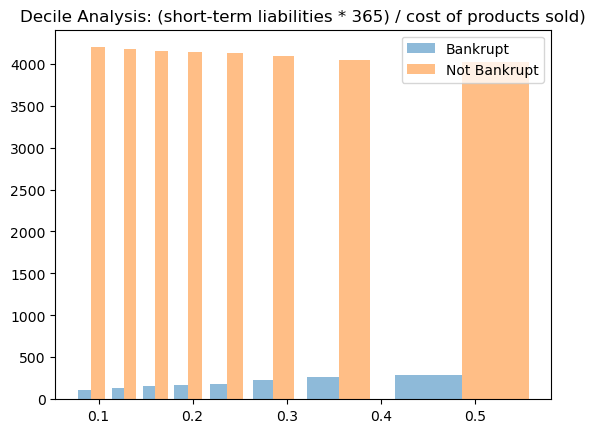

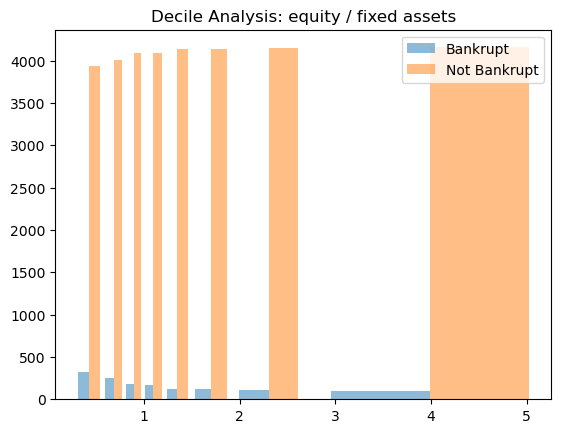

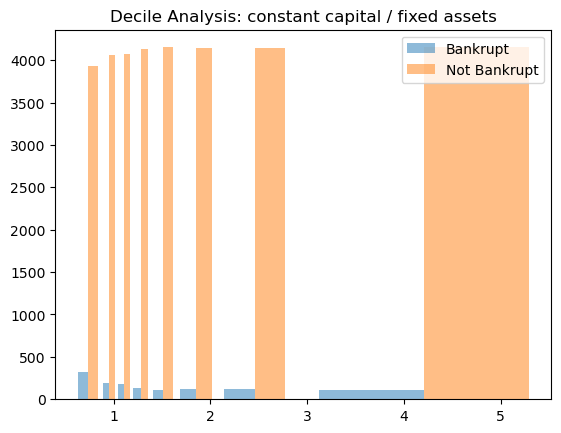

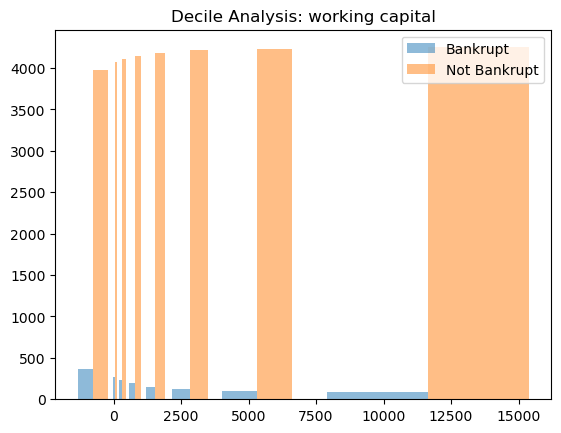

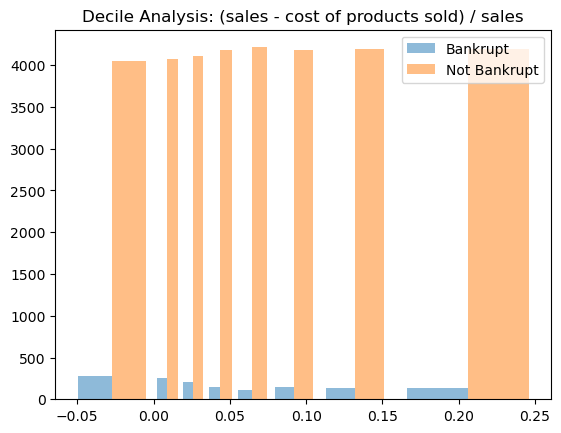

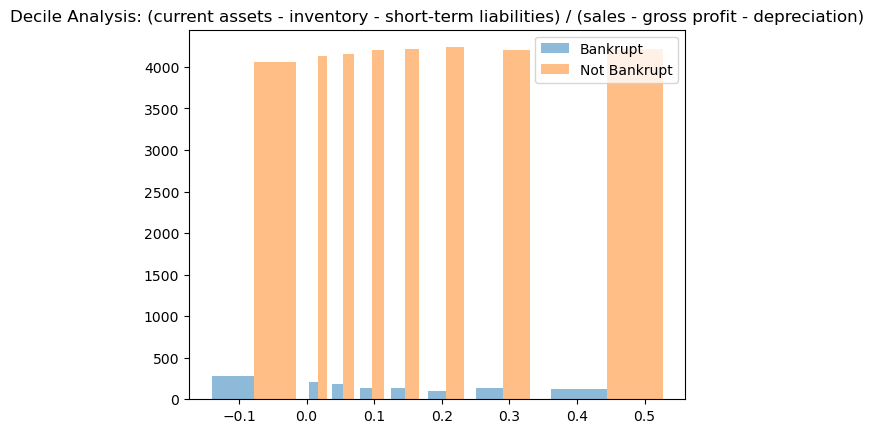

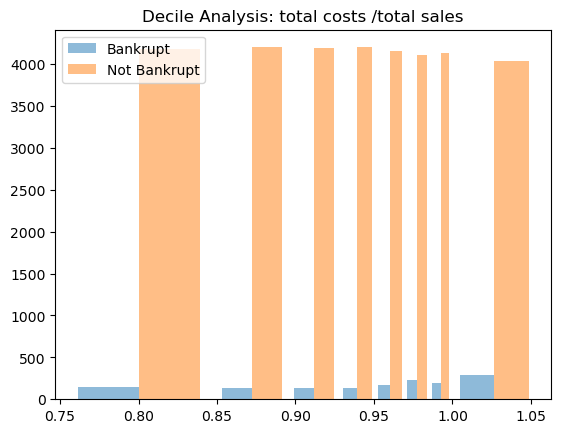

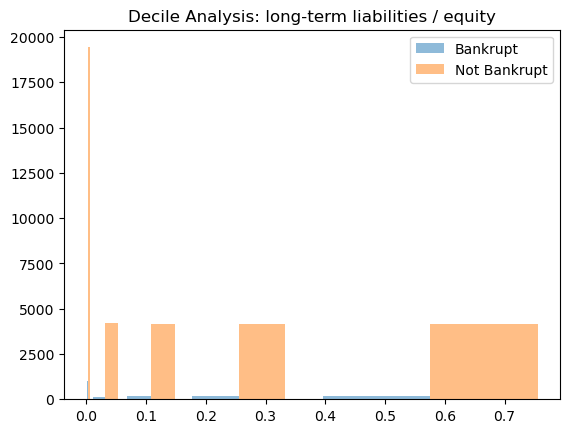

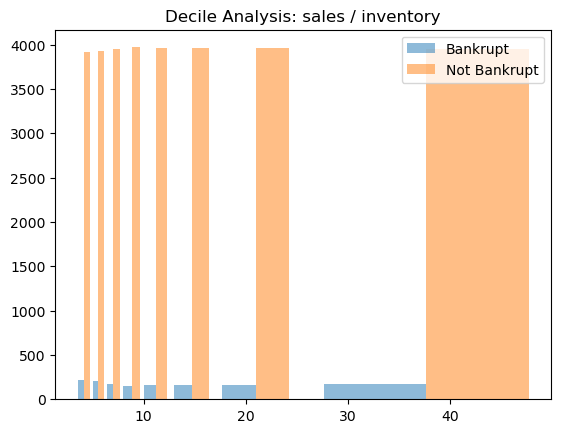

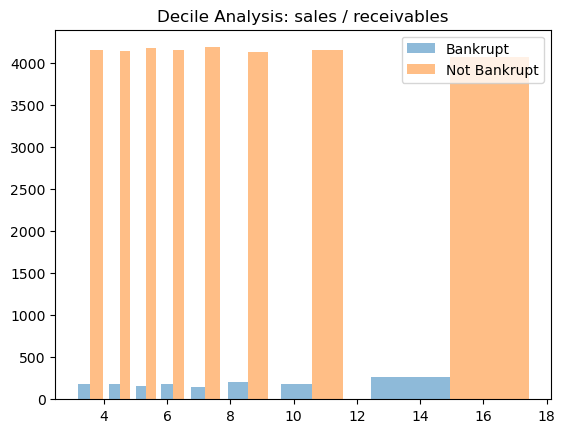

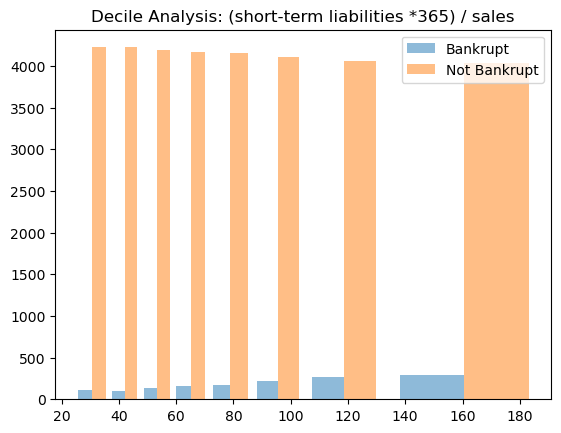

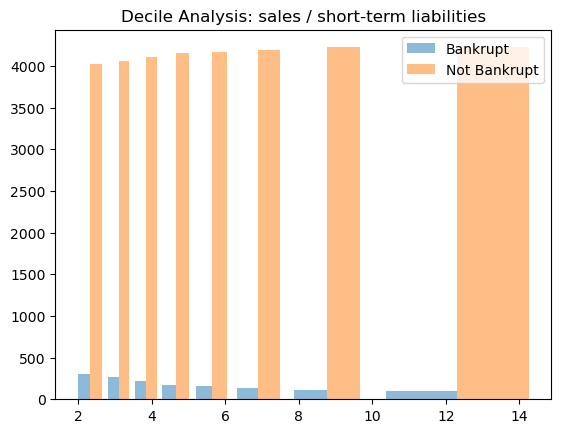

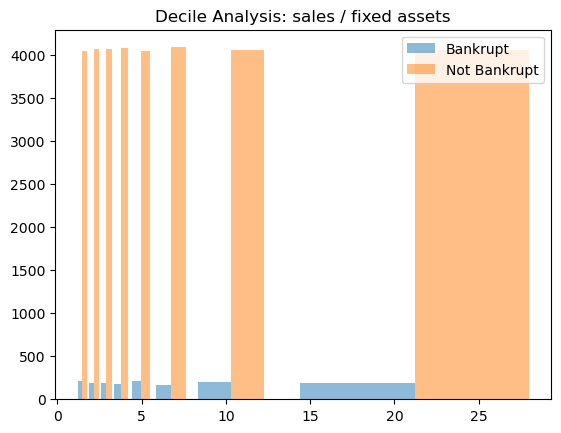

In [65]:
#### Due to variance of data, initial review of histograms difficult to understand exactly which variables are of importance and impact of outlining values, given relatively small occurances of many

decile_value_df = pd.DataFrame()

for i in df1.columns:
    if i == "BANKRUPTCY_FLAG":
        pass
    else:    
        decile_value_df = pd.concat([decile_value_df,create_decile(df1,i)])

In [69]:
column_inclusion_review_df = create_column_inclusion_review(df,
                                                            og_columns,
                                                            column_type_df,
                                                            decile_value_df)
column_inclusion_review_df.to_excel('column_inclusion_review_df.xlsx',index=False)
column_inclusion_review_df

,Financial Ratio,null_records,zero_records,max_value,min_value,mean_value,std_dev,positive_values,negative_values,Value Between 0 to 1,...,Ratio Classification,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,net profit / total assets,8,240,94.28,-463.89,0.04,2.99,33865,9292,33999,...,Profitability Ratio,-0.09,-0.01,0.01,0.03,0.05,0.08,0.11,0.15,0.24
1,total liabilities / total assets,8,89,480.96,-430.87,0.59,5.84,43305,3,41116,...,Liqudity Ratio,0.13,0.22,0.31,0.39,0.47,0.55,0.64,0.74,0.88
2,working capital / total assets,8,24,28.34,-479.96,0.11,5.44,33804,9569,33797,...,Capitalization Ratio,-0.15,-0.02,0.06,0.13,0.20,0.27,0.36,0.46,0.60
3,current assets / short-term liabilities,134,2,53433.00,-0.40,6.31,295.43,43267,2,9569,...,Capitalization Ratio,0.71,0.96,1.14,1.33,1.57,1.90,2.42,3.32,5.53
4,[(cash + short-term securities + receivables -...,89,43,1250100.00,-11903000.00,-385.35,61243.03,21356,21917,319,...,Profitability Ratio,-134.63,-65.60,-36.54,-16.94,-1.03,16.05,37.02,68.51,145.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,sales / receivables,102,122,108000.00,-12.66,17.03,553.05,43175,6,670,...,Turnover Ratio,3.08,4.08,4.92,5.72,6.64,7.77,9.34,11.83,18.06
61,(short-term liabilities *365) / sales,127,121,25016000.00,-2336500.00,1502.33,139266.70,43153,4,157,...,Turnover Ratio,24.40,36.56,47.50,58.83,71.33,86.46,104.77,132.46,188.74
62,sales / short-term liabilities,134,118,23454.00,-1.54,9.34,124.18,43149,4,1539,...,Turnover Ratio,1.90,2.73,3.46,4.20,5.09,6.16,7.63,9.89,14.74
63,sales / fixed assets,812,88,294770.00,-10677.00,72.79,2369.34,42500,5,3437,...,Turnover Ratio,1.15,1.84,2.53,3.30,4.28,5.63,7.89,12.73,29.65


## Review Correlations with Data.

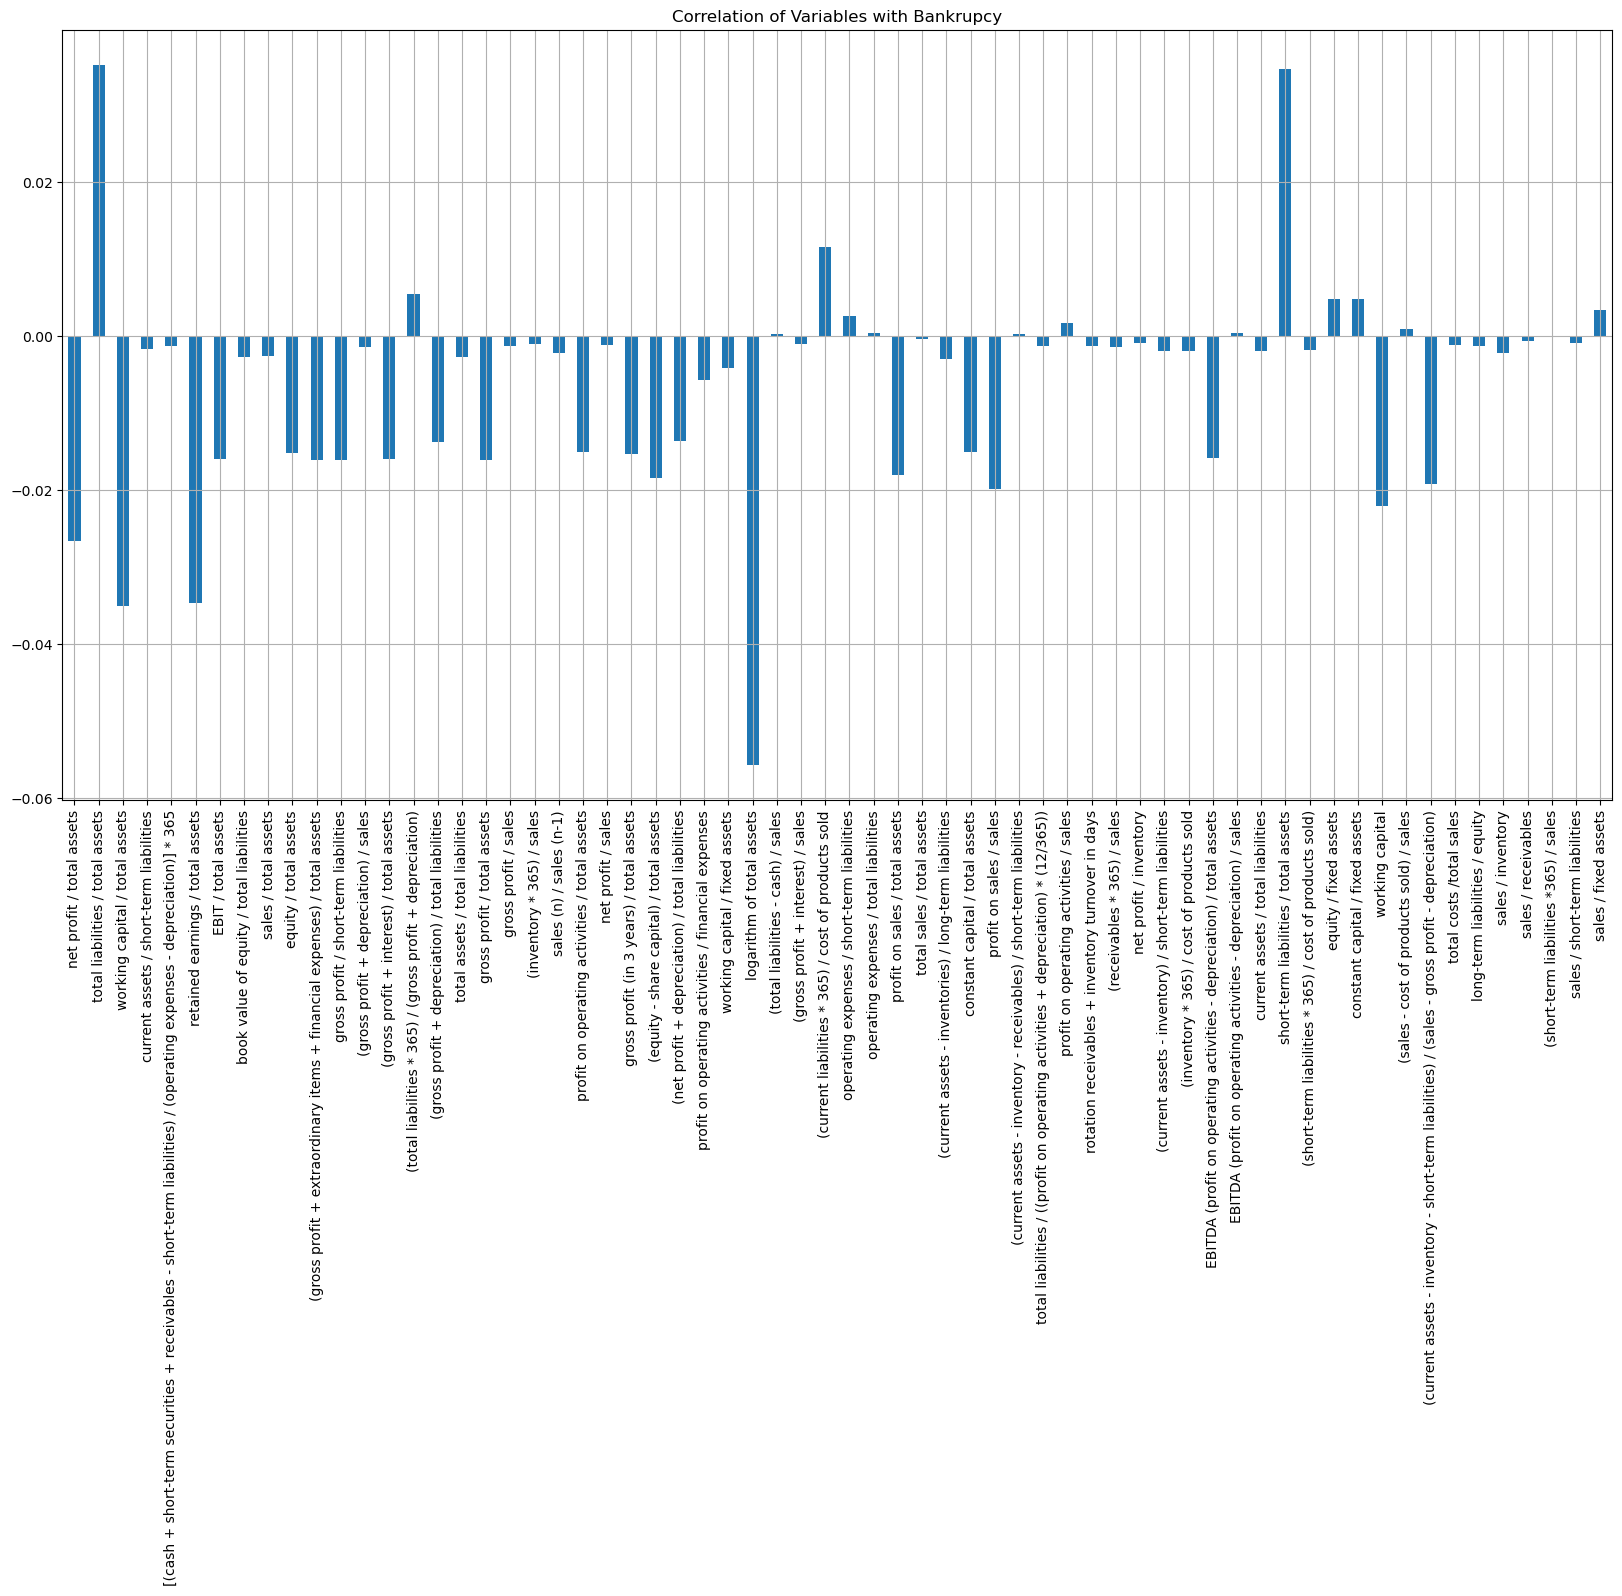

In [70]:
df1.drop(['BANKRUPTCY_FLAG'],axis=1).corrwith(df.BANKRUPTCY_FLAG).plot.bar(figsize=(20,10),title='Correlation of Variables with Bankrupcy',rot=90,grid=True)
plt.show()

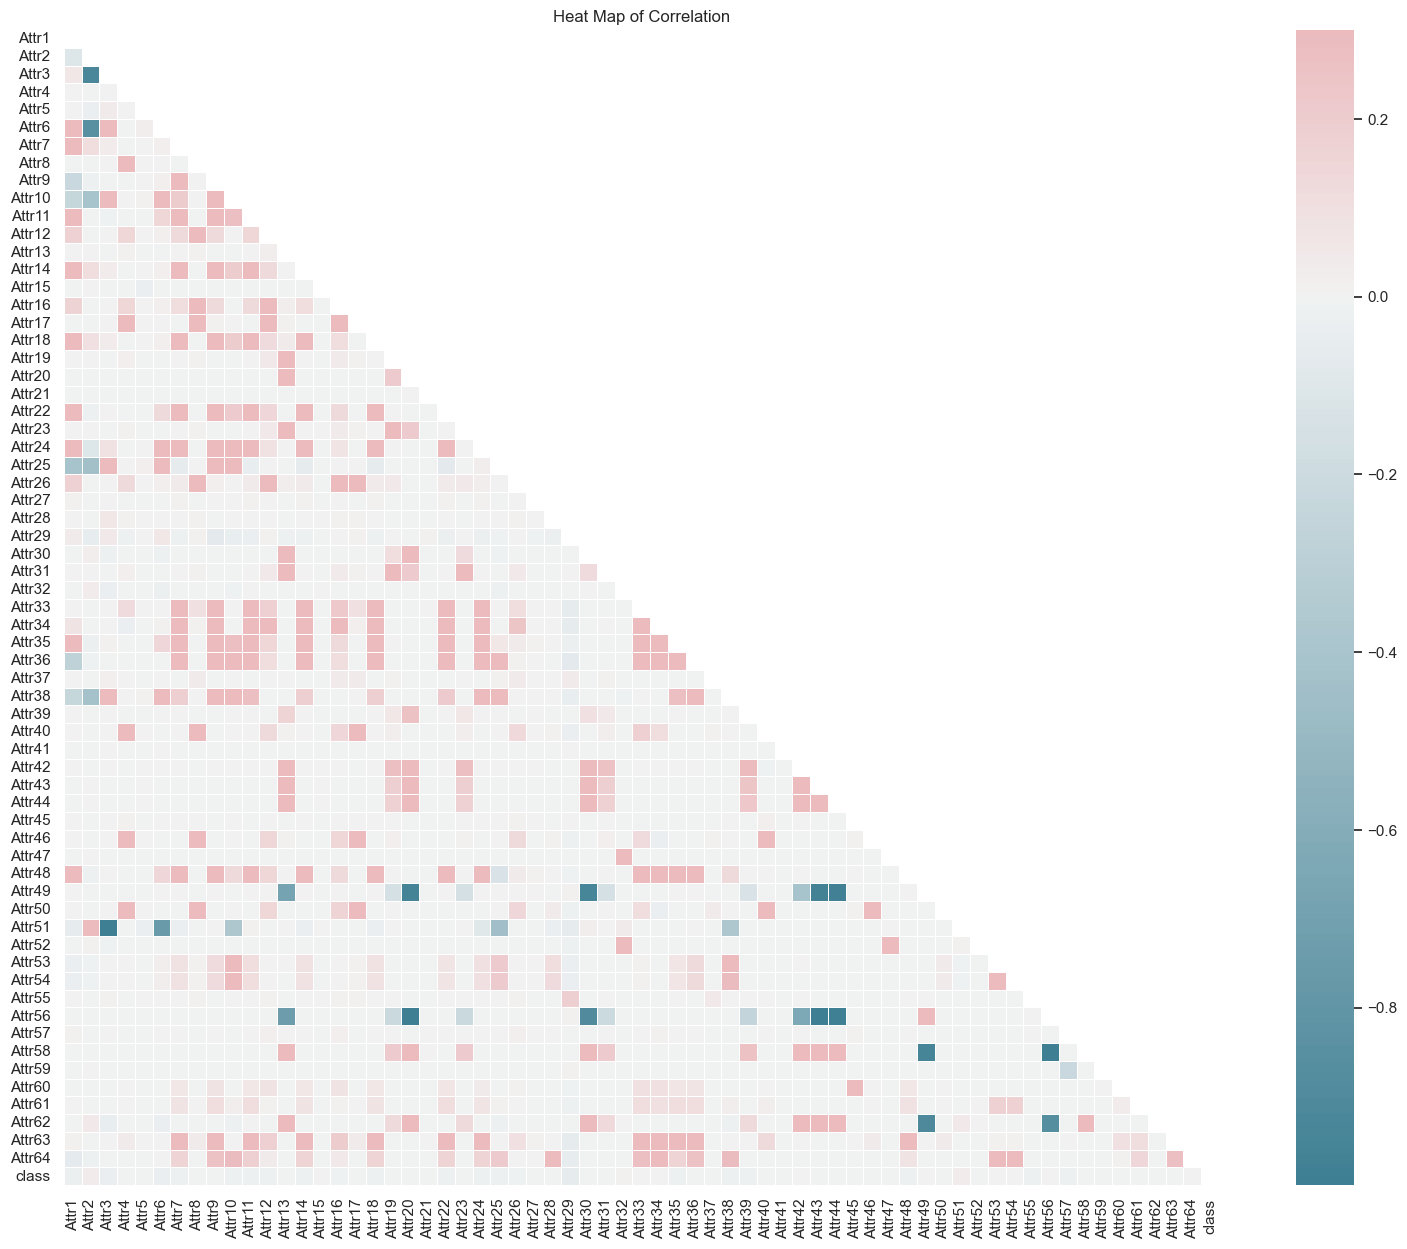

In [72]:
create_heatmap(df1.rename(columns={column_data.iloc[x]['FINANCIAL_RATIO']:column_data.iloc[x]['COLUMN_NAME'] for x in range(0,len(column_data))})) 

### After reviewing the initial EDA Histogram, Decile Analysis, Column Names and Correlations what do we know.


1. Considerable blanks on certain variables.
2. Correlation amongst variables appears to be a concern, could be a problem. Specifically, multicolinearity.
3. Outliers are skewing meaningful interpretation of Histogram. Utilized Decile to partially overcome, how do these impact model?

## Data Clean Up.


In [ ]:
# There are 2 approaches we can take, we can look at the Record Level, or we can look at the Variable Level.
# Given some assumptions related to the approach we will be taking, we will start at the variable level. Specifically, 
# Based on the number of blanks for certain variables, such as Sales, Inventory and Debt, we will likely be 
# removing a number of variables from the dataset and thus might have fewer omissions on the individual company level

In [ ]:
# We will start our review at the Individual Variable Level and determine relative importance and whether it should be 
# retained or removed.


## Tier 1 Variables

,Financial Ratio,Ratio Classification
0,net profit / total assets,Profitability Ratio
1,total liabilities / total assets,Capitalization Ratio
2,working capital / total assets,Liqudity Ratio
5,retained earnings / total assets,Capitalization Ratio
28,logarithm of total assets,Capitalization Ratio
50,short-term liabilities / total assets,Capitalization Ratio
54,working capital,Liqudity Ratio


In [169]:
# Based on Correlation with Bankrupcy we have identified 6 Variables as Tier1.

tier1 = ['net profit / total assets',
         'total liabilities / total assets',
         'working capital / total assets',
         'retained earnings / total assets',
         'logarithm of total assets',
         'working capital',
         'short-term liabilities / total assets']

column_inclusion_review_df[column_inclusion_review_df['Financial Ratio'].isin(tier1)][['Financial Ratio','Ratio Classification']]

# Review Each of these through process: 
# 1. How to treat NA
# 2. How to Outliers
# 3. How to treat Similiar Variables
# 

,Financial Ratio,Ratio Classification
0,net profit / total assets,Profitability Ratio
1,total liabilities / total assets,Capitalization Ratio
2,working capital / total assets,Liqudity Ratio
5,retained earnings / total assets,Capitalization Ratio
28,logarithm of total assets,Capitalization Ratio
50,short-term liabilities / total assets,Capitalization Ratio
54,working capital,Liqudity Ratio


## Data Cleaning Process

In [ ]:
variable_review(df,
                    column_name,
                    og_column,
                    column_inclusion_review_df,
                    corr_weight=.15):

                                               0
Financial Ratio        net profit / total assets
null_records                                   8
zero_records                                 240
max_value                                  94.28
min_value                                -463.89
mean_value                                  0.04
std_dev                                     2.99
positive_values                            33865
negative_values                             9292
Value Between 0 to 1                       33999
Value between -1 to 0                       9106
Value Less than -1%                          186
Value Greater than 1                         106
Ratio Classification         Profitability Ratio




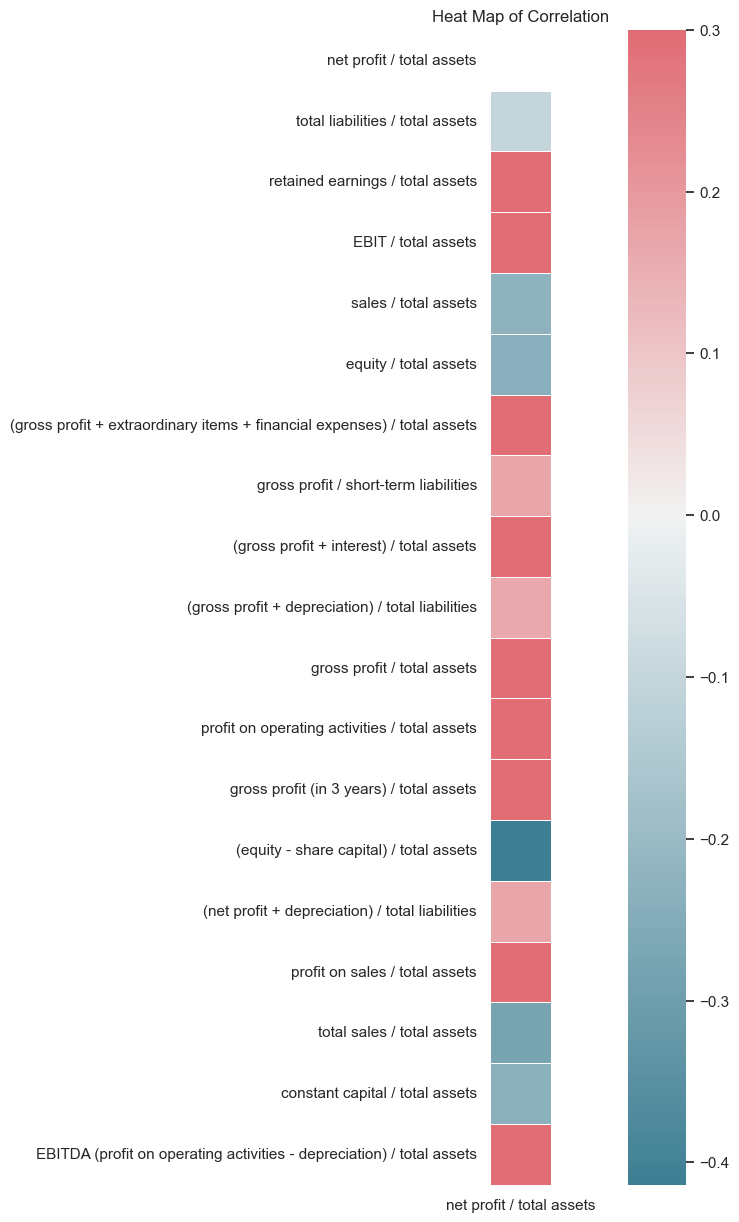

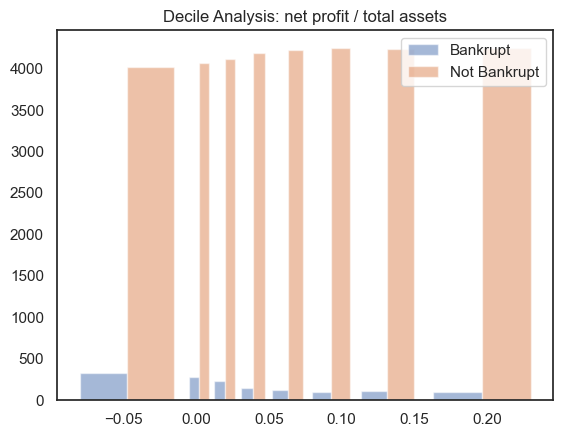

Top 20 Records
       net profit / total assets  BANKRUPTCY_FLAG
5844                        5.53                1
8242                        7.14                0
4349                        7.37                0
10024                       7.37                1
9578                        9.80                1
9741                       10.50                0
3466                       15.50                0
10321                      20.48                1
4047                       20.48                0
8042                       52.65                0
4351                       87.46                0
5787                       94.28                0
7762                         NaN                0
1783                         NaN                0
4884                         NaN                0
5880                         NaN                1
2898                         NaN                0
1900                         NaN                0
5334                         NaN   

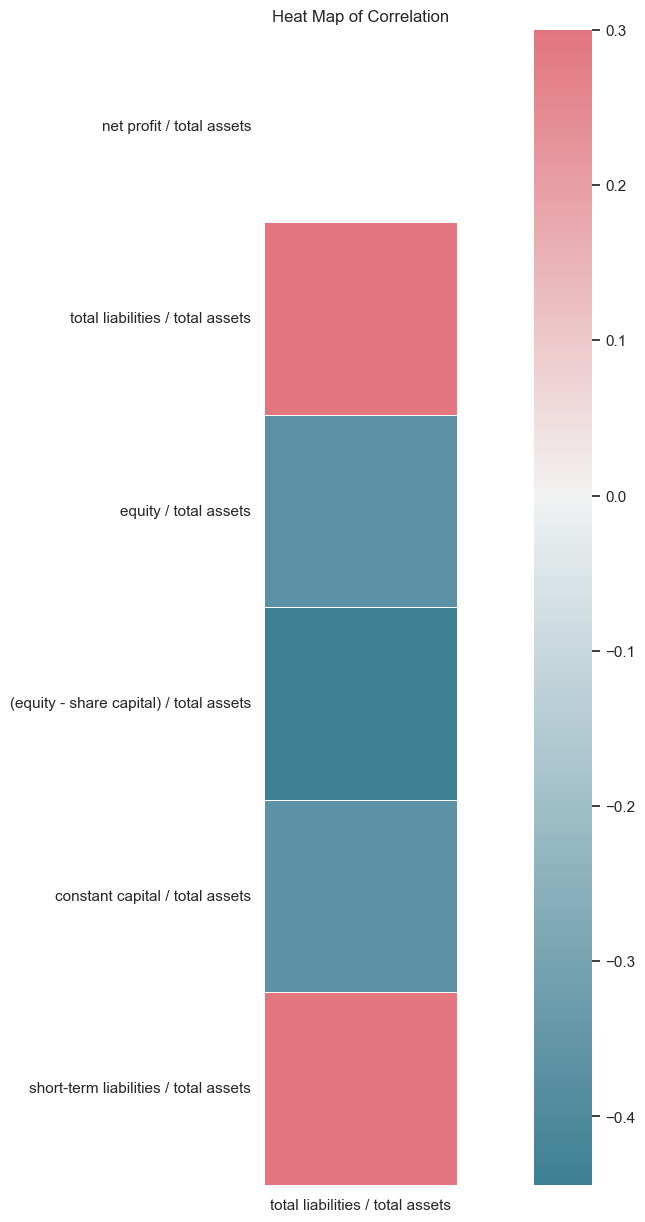

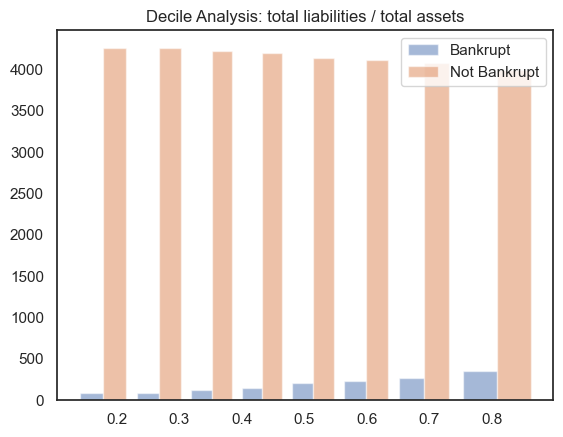

Top 20 Records
       total liabilities / total assets  BANKRUPTCY_FLAG
6800                              16.64                0
1499                              16.67                0
5001                              20.40                0
3466                              21.26                0
1497                              24.91                0
3017                              25.00                0
1392                              25.43                0
1672                              25.64                0
9587                              40.16                1
5761                              46.03                1
1456                              46.91                0
8242                              54.23                0
5613                              72.42                1
5323                             110.69                0
6921                             441.50                1
4232                             441.74                0
10321           

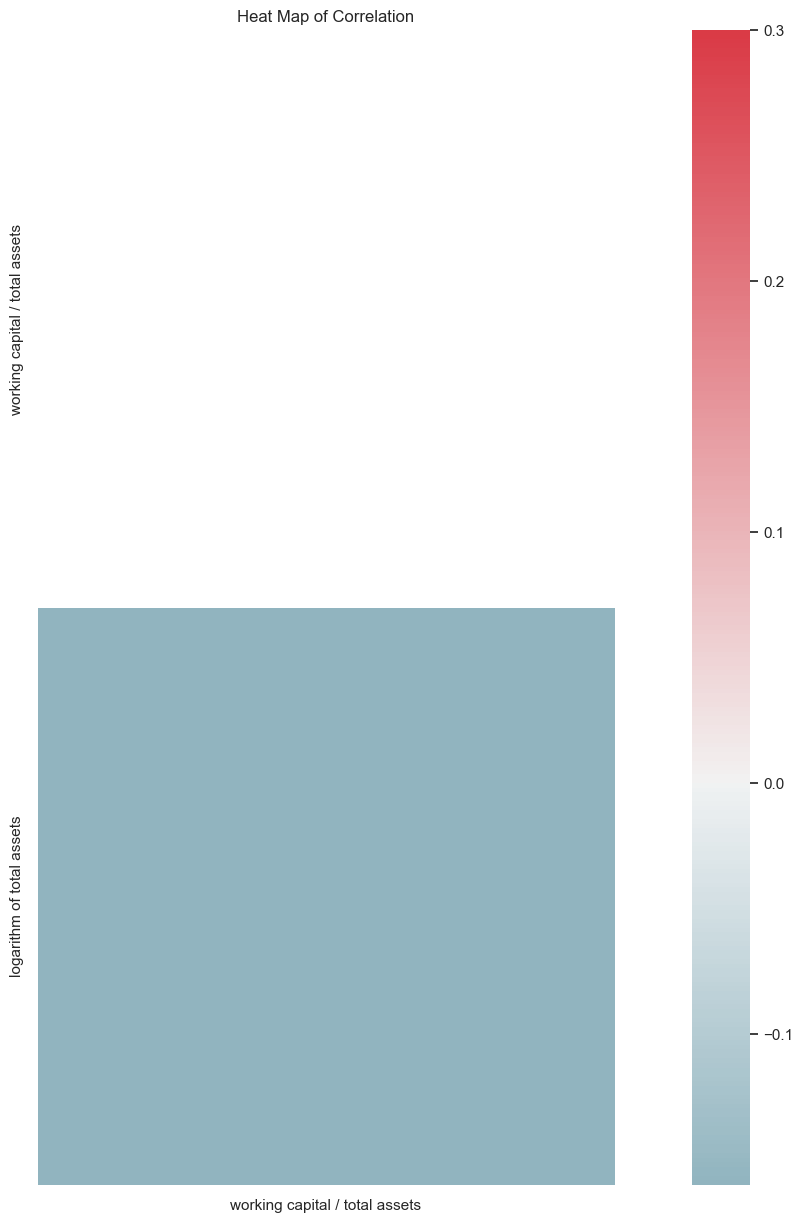

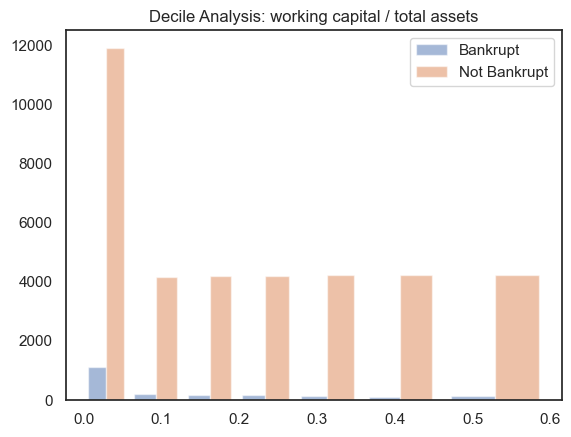

Top 20 Records
      working capital / total assets  BANKRUPTCY_FLAG
7509                            1.00                0
4200                            1.00                0
279                             1.00                0
4318                            1.00                0
7271                            1.00                0
4115                            1.00                0
6110                            1.00                0
5583                            1.00                1
2619                            1.00                0
2051                            1.00                0
6924                            1.05                0
4148                            1.39                0
3073                            4.18                0
2457                            5.50                0
2496                            9.63                0
3131                           11.93                0
1555                           17.63                0
2503         

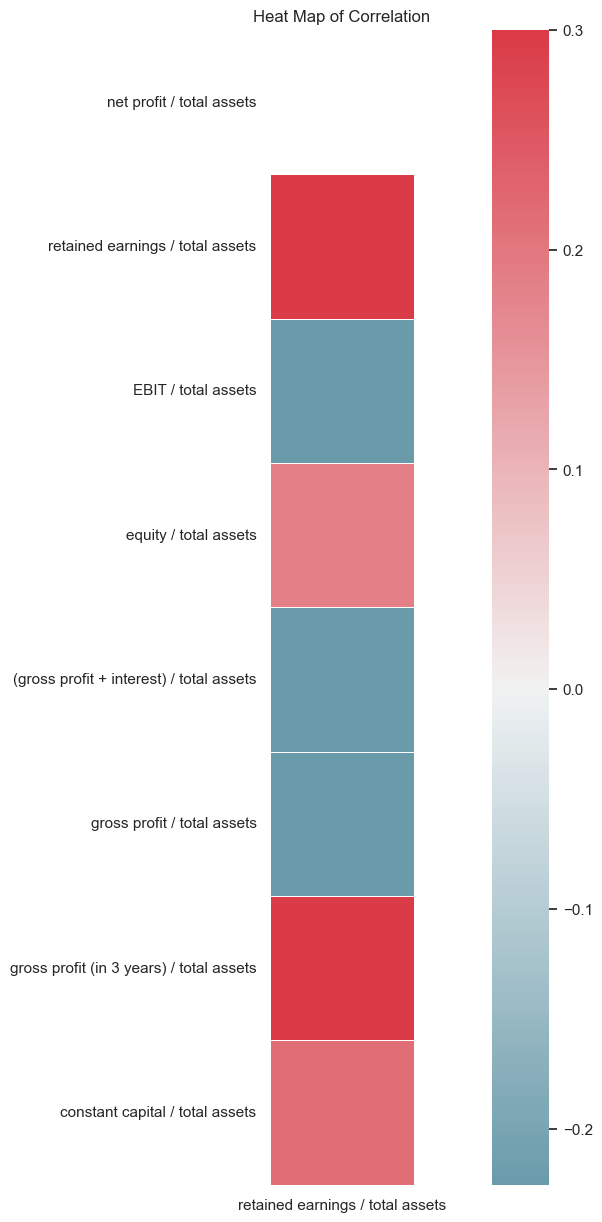

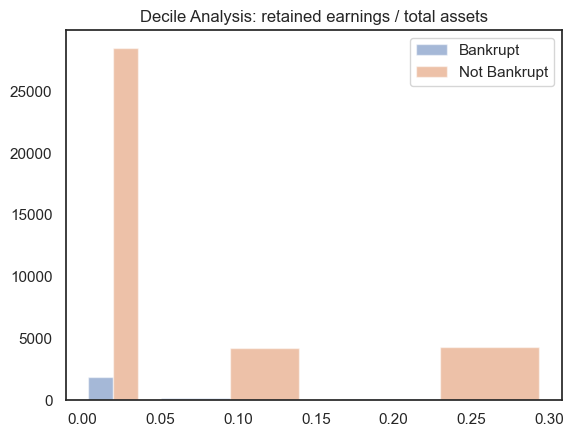

Top 20 Records
      retained earnings / total assets  BANKRUPTCY_FLAG
7932                              4.55                0
4472                              7.80                0
5087                             14.76                0
5681                             17.11                0
9741                             25.41                0
3908                             27.53                0
9827                             35.55                1
3466                             36.74                0
5291                             39.15                0
6293                             40.51                0
8042                             45.53                0
3704                             63.02                0
660                              75.26                0
3422                             77.49                0
5732                            137.05                0
1195                            203.15                0
1032                            2

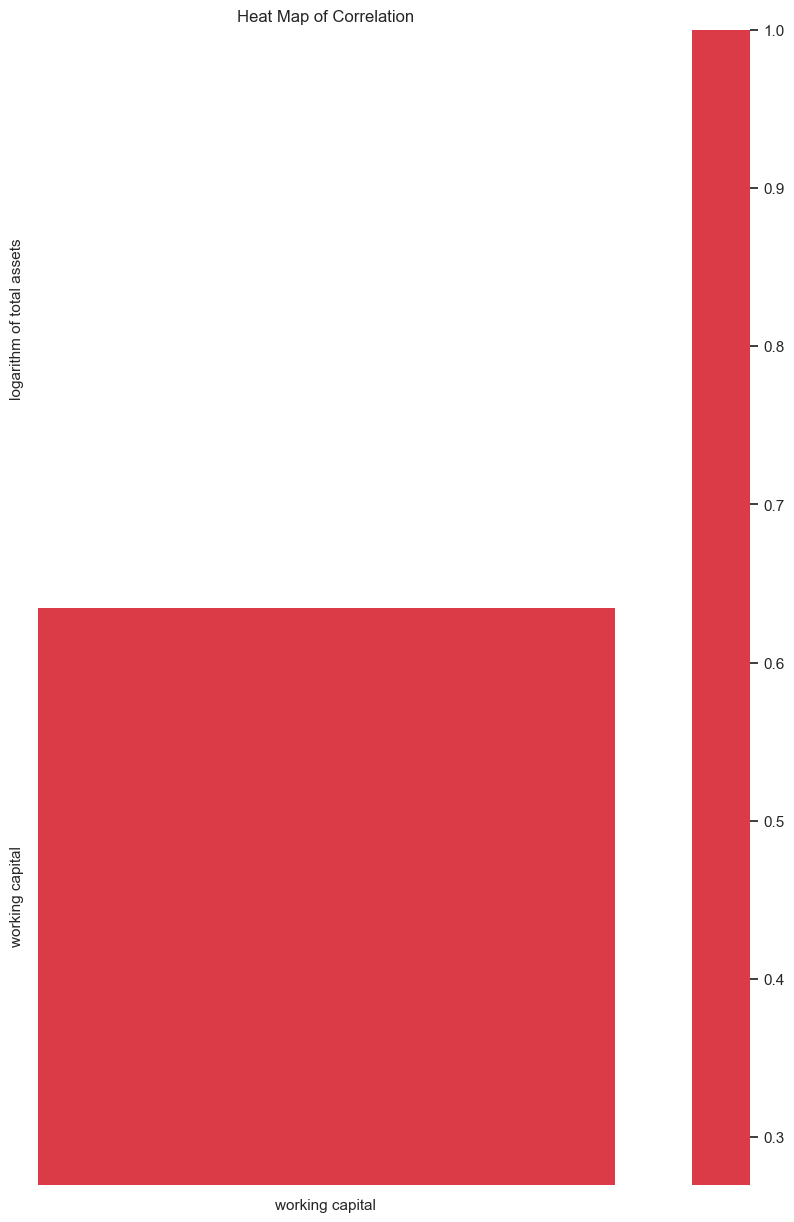

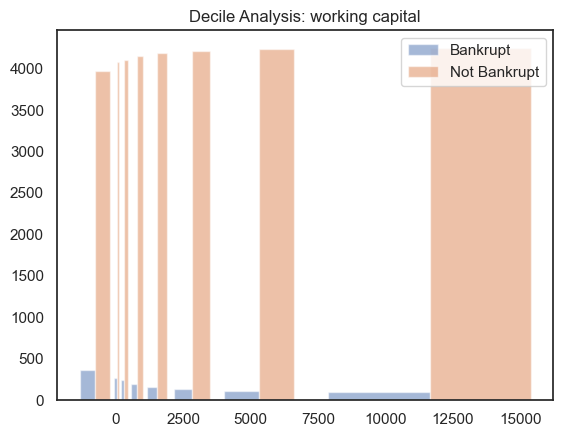

Top 20 Records
      working capital  BANKRUPTCY_FLAG
3869        991610.00                0
2776       1011200.00                0
1701       1016000.00                0
5769       1076400.00                0
5794       1108900.00                0
3881       1139900.00                0
6398       1174500.00                0
1749       1273500.00                0
3730       1345600.00                0
5959       1355800.00                0
2567       1406500.00                0
1593       1634200.00                0
315        2152200.00                0
9670       2653200.00                0
428        3178000.00                0
435        3380500.00                0
9460       3657400.00                0
5244       4212200.00                0
6517       4398400.00                0
8962       6123700.00                0
Bottom 20 Records
      working capital  BANKRUPTCY_FLAG
5947      -1805200.00                0
3674      -1118500.00                0
8723       -937480.00          

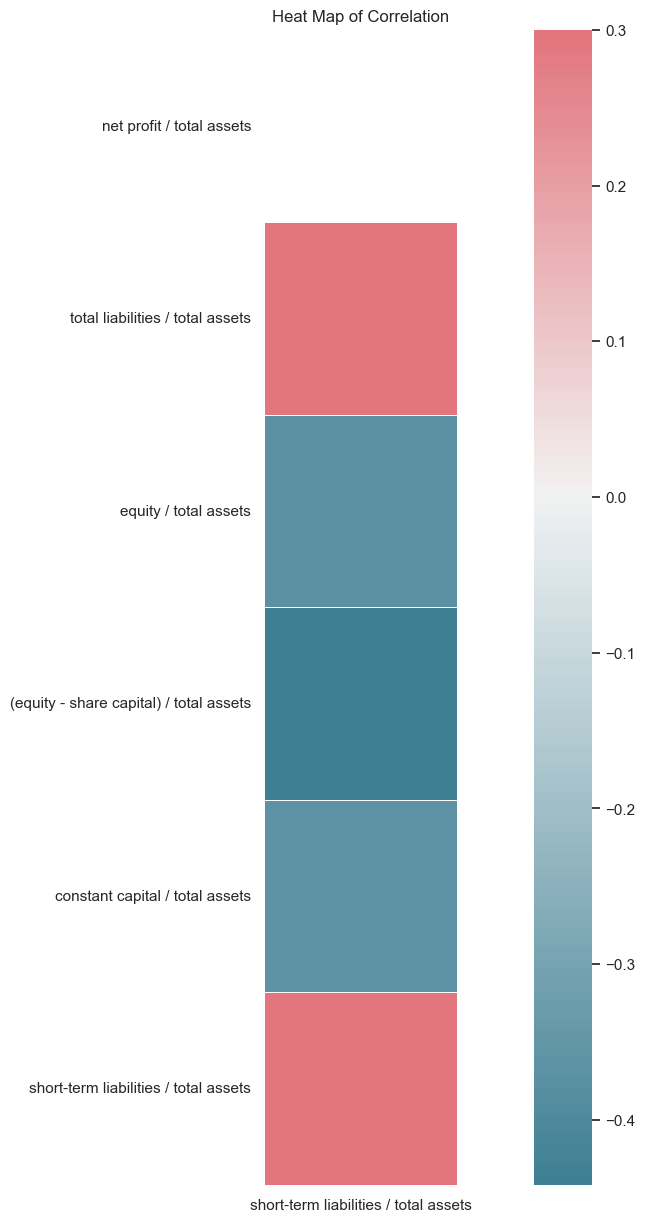

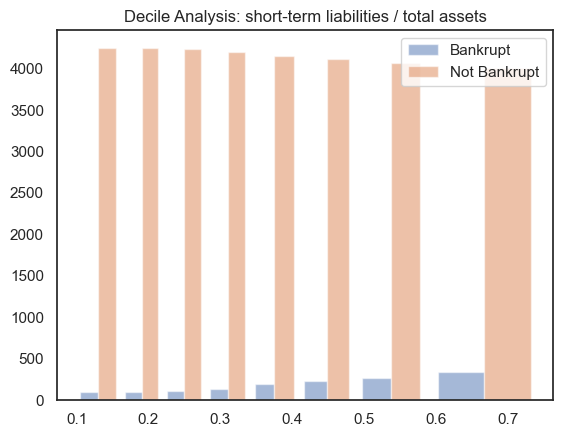

Top 20 Records
       short-term liabilities / total assets  BANKRUPTCY_FLAG
5087                                   14.54                0
9662                                   15.02                1
7776                                   15.72                0
5259                                   16.49                0
1499                                   16.67                0
5001                                   20.40                0
3466                                   21.26                0
1497                                   24.91                0
1392                                   25.43                0
1672                                   25.64                0
1456                                   46.91                0
8242                                   54.23                0
5613                                   72.42                1
5323                                  110.69                0
6921                                  441.50           

""
net profit / total assets
total liabilities / total assets
working capital / total assets
current assets / short-term liabilities
[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
...
sales / fixed assets
BANKRUPTCY_FLAG
dataset
remove_reason


In [196]:
# Review Variable
variable_review(df,'net profit / total assets',og_columns,column_inclusion_review_df)

# Utilize Function to clean Dataframe
clean_df = data_cleaning(df,remove_records=1,clean_records=1)


# Update column_inclusion_review_df with Cleaned Information
column_inclusion_review_df = create_column_inclusion_review(clean_df[clean_df['remove_reason']==''],
                                                                     og_columns,
                                                                     column_type_df,
                                                                     decile_value_df)

# Review Other Tier 1, Given inclusion of above, these will be already Cleaned
# If looking to replicate original review, utilize df, opposed to clean_df

variable_review(clean_df[clean_df['remove_reason']==''],'total liabilities / total assets',og_columns,column_inclusion_review_df)
variable_review(clean_df[clean_df['remove_reason']==''],'working capital / total assets',og_columns,column_inclusion_review_df)
variable_review(clean_df[clean_df['remove_reason']==''],'retained earnings / total assets',og_columns,column_inclusion_review_df)
variable_review(clean_df[clean_df['remove_reason']==''],'working capital',og_columns,column_inclusion_review_df)
variable_review(clean_df[clean_df['remove_reason']==''],'short-term liabilities / total assets',og_columns,column_inclusion_review_df)

# Utilize Cleaned Dataframe

In [180]:
def data_cleaning(df,
                  remove_records=0,
                  clean_records=0):
    
    new_df = df.copy()
   
    # Remove Data
    if remove_records==1:
        
        # There are 8 Instances of Profit / Assets NA. 7 Not Bankrupt, 1 Bankrupt. These 8 instances are all blanks amongst tier 1, remove. Low Risk to information loss        
        # Single Company with no entry, not a bankrupt company, company also has many other blanks. Low Risk of Information loss
        
        
        conditions = [new_df['net profit / total assets'].isnull(),
                     new_df['working capital'].isnull()]
                     
        values = ['Net Profit/ Total Assets is Null',
                  'Working capital is Null']
        
        new_df['remove_reason'] = np.select(conditions,values,"")
        
        print(new_df['remove_reason'].value_counts())
            
    
    if clean_records==1:
    # Ratio meant to capture the Profitability of Assets. If company does not make a profit then this ratio 
    # doesn't necessarily have the same negative implication. Curtail at 0.
        new_df['net profit / total assets'] = np.where(new_df['net profit / total assets']<0,0,new_df['net profit / total assets'])

    # total liabilities / total assets meant to capture the amount of debt relative to the value of company.
    # A negative ratio does not have meaninful interpretation. 
    
        new_df['total liabilities / total assets'] = np.where(new_df['total liabilities / total assets']<0,0,new_df['total liabilities / total assets'])
        
    # Ratio Meant to Capture the amount of assets which are readily available in the short term to pay debt.
    # A negative Ratio does not have a meaningul interpretation, 0 means the company has no money in the immediate to pay debt
        new_df['working capital / total assets'] = np.where(new_df['working capital / total assets']<0,0,new_df['working capital / total assets'])
        
    # Ratio meant to Capture what Percentage of Assets are financed by Retained Earnings (Versus Debt).
    # This ratio is slightly problematic, because Negative Retained Earnings is technically possible, which is 
    # a material warning sign, meaning the company is financed completely by Debt. Will Cap at 0, which implies 
    # that the company is financed 100% by debt, which is a accurate technical interpretation
        
        new_df['retained earnings / total assets'] = np.where(new_df['retained earnings / total assets']<0,0,new_df['retained earnings / total assets'])
        #new_df[''] = np.where(new_df['']<0,0,new_df[''])
        
    # Negative Logarithm implies a value of Assets between 0 and 1, which tantamounts to having no assets. 
    # equivalent of 0, given low frequency of examples, capping value at 0,
    
        new_df['logarithm of total assets'] = np.where(new_df['logarithm of total assets']<0,0,new_df['logarithm of total assets'])
        #new_df[''] = np.where(new_df['']<0,0,new_df[''])
        
    # Variance in Working Capital Material. Negative working Capital, similiar in meaning to no working capital, in 
    # that not having the ability to pay bill is very bad, and technically, negative assets and negative liabilties 
    # shouldn't exist, they should simply become the opposite, as such a negative assets is a liability, which 
    # reduces working capital, thus net negatives to 0.
    
    # also, given Huge variance, create a new variable, Logarithim in attempt to build importance of high number,
    # while keeping scale consistent.
        
        new_df['logarithim of working capital'] = np.where(new_df['working capital']<1,1,new_df['working capital'])
        new_df['logarithim of working capital'] = new_df['logarithim of working capital'].apply(lambda x:np.log(x))
    
    # Similar Logic, shouldn't be negative values, Higher more risky, removing 1 instance, which was a noted Bankrupt, although differences
    # to value is nominal.
    
        new_df['short-term liabilities / total assets'] = np.where(new_df['short-term liabilities / total assets']<0,0,new_df['short-term liabilities / total assets'])
 
    return new_df

clean_df = data_cleaning(df,
                         remove_records=1,
                         clean_records=1)

remove_reason
                                    43396
Net Profit/ Total Assets is Null        8
Working capital is Null                 1
Name: count, dtype: int64


In [ ]:
# Count Occurances of Null for individual Records
df['OBSERVATION_NULL_CNT'] = df.isnull().sum(axis=1)

## Create Baseline Models Using Tier 1 Variables

1. Do the variables identified in Tier 1 provide a sufficient basis to attempt initial model review and creation?<br>
Based on identified ratios, they cover 3 of the 4 categories (Turnover not covered) <br>
We will need to potentially replace Working Capital with created Log variable <br>
We will need to see if our variable clean up was effective <br>
We will need to establish a baseline comparison and use our simple model to see if it can outperform more complex and exhaustive variables




In [ ]:
tier1 = ['net profit / total assets',
         'total liabilities / total assets',
         'working capital / total assets',
         'retained earnings / total assets',
         'logarithm of total assets',
         'working capital',
         'logarithim of working capital',
         'short-term liabilities / total assets']

In [ ]:
def create_binary_baseline_reference(df):
    df['NOT_PROFITABLE'] = np.where(df['net profit / total assets']==0,1,0)
    df['NO_LIQUIDITY'] = np.where(df['logarithim of working capital']==0,1,0)
    df['LIABILITIES_GT_ASSETS'] = np.where(df['total liabilities / total assets']>1,1,0)
    df['NO_EQUITY'] = np.where(df['retained earnings / total assets']==0,1,0)
    df['ST_OBLIGATIONS_GT_TOTAL_ASSETS'] =np.where(df['short-term liabilities / total assets']>1,1,0)
    
    return df


### Split DataFrame into Train, Test, and Validation Data Sets

In [ ]:
X = df.drop('BANKRUPTCY_FLAG',axis=1).copy()
y = df['BANKRUPTCY_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create Synthetic Data To Test Model

In [ ]:
from sklearn.datasets import make_classification

# Set a random seed for reproducibility
np.random.seed(42)

# Generate synthetic dataset
X, y = make_classification(n_samples=10000, n_features=64, n_informative=64, n_redundant=0, n_clusters_per_class=1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
len(X_train[0])

In [ ]:
history,model = train_model(X=X_train,
                y=y_train,
                input_dim=len(X_train[0]),
                metrics=['accuracy', keras.metrics.Precision()],
                hidden_layer_sizes=[8,16,32,64],
                activation='relu', 
                optimizer='adam',
                learning_rate=0.05,
                batch_size=30000,
                num_epochs=64,
                validation_split=.3,
                verbose=0)

In [ ]:
predictions = model.predict(X_train)
np.round(predictions)